In [124]:
####################### SWITCH FOR PLOTTING ########################
# Set to false to produce a large number of exploratory plots
# When False, only a few images are produced.
#
SHOW_ALL_PLOTS = True
#
#
#####################################################################


### results

![errors](errors.png)
![dm](dm.png)



# Coinfilp Problem Statement

The attachment contains:
1. Data dictionary 

2. Training dataset for model building 

3. Testing dataset for submission 

## Problem statement: 

Given is the hourly rental data of an e-scooter rental company. The goal is to predict the total number of e-scooters rented per hour. We recommend using Python for this assignment and are free to use any packages and IDE.  Submissions are evaluated based on how the candidate is able to explore the data using charts, correlation matrix, etc.; and prediction using various modeling methods, the Root Mean Squared Logarithmic Error (RMSLE) as potential evaluation metrics.  

 

## Some guidance: 

Pls submit your analysis/code in Python Notebook, you can show the following results:

1. data pre-processing, feature generation

2. data exploration analysis and visualization

3. modeling - algorithms choices and optimization 

4. final model performance analysis, feature importance 

5. Based on the parameters provided in the testing data, you can use the trained model above (or retrain the model with different set of variables) to predict counts, and add the "count" column in the testing data and submit it.

## Data Description

datetime - hourly date + timestamp 
 
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 
1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [126]:
# begin discussion

# Introductory Discussion

## Strategy for Prediction of Total Scooter Rentals By Hour
* to predict `count`, we make two models, each trained with same training set and input X, each predicting one of the dependent variables `casual`, and `registered`
* this is necessary because `registered` rentals and `casual` rentals depend stroingly on disjount sets of inputs
* while both estimators show there is a dependence on the cyclic time varibles and obvious weather patterns (weekends result in larger rentals of both kinds... good weather results in more ridership, both rental totals increase overall as time moves forward on the scale of years, and are periodic in day, week, and year) ... 
* But, there are some major differences
    - registered rentals are less sensitive to ambient weather and the existence of a holiday, or other non-working day
    - registered rentals stronly depend on the interaction of the workweek with thet time-of-day (rush-hour!)
    - casual rentals depend more strongly variables of circumstance and display larger variance

See eda*.ipynb for interactive exploration leading to the following strategies.
## Removal of Correlated inputs
* we are dropping atemp because temp and atemp have $r^2=0.97$

Atemp has corrupted values and is otherwise highly correlted with temp.


# Procedure
* EDA
* Data Preprocessing
* Model interaction
* Results


# Findings from EDA
## Independent Variable Interactions

* season, month, year all interact a little
* workingday and hour interact very strongly.  To see why, set `SHOW_ALL_PLOTS=True` and run the cells below, or check the EDA notebooks.
* some other interactions are built, see `get_dx: function`

## Model Choice and Encoding
* a linear model may only perform well if non-monatonic and categorical vartiables are one-hot-encoded.
* for example, season itself becomes four one-hot features
* temperature is a continuous variable but the boxplot analysis shows the impact is NOT exactly monatonic, much less linear.


# Preprocessing
### Encoding Select Interactions `weekday*time`,`workday*hour`,`month*year`, etc

We capture the time interactions by creating several additionalvariables by multuplying (concatenating the labels of) year, month, hour, season

* workingday_hr
    - on working days, there is a huge impact on the registered rentals at 8am and 5pm.
    - the impact is less pronouces on casual rentals but is present.
    - this is a crucial interaction.
    - here we encode "{workingday},{hour}" as a feature for a total of 2*24 = 48 features in the one-hot-encoded resulting X matrix.

* holiday is tempting, but holiday interactions are redundant with workingday interactions

* over months, years, the total (EMA) number of rentals rises!
    * `month -> f'{year},'{month'}'`
    * `week-> f'{year},{week}'` etc
* hr_season
    - the time of sunup, sundown is probably relevant to the impact of time of day on the counts
    - here we encode "{hour},{season}" as a feature

* yr_month
    - the month alone is not as helpful because of the ever increasing popularity of the scooter
    - it is relevant if it is the first or second May, for example
    - here we encode "{year},{month}" as a feature
    
* yr_season
    - likewise, to separate season from the upward popularity, encode "{year},{season}"
    - could also try "{month},{season}" but dont want to overfit for a first pass


## Accounting for Linear + Cyclic Time Relationships

* As time goes on (see below), the number of rentals increases
* dependent variables are periodic in time
* we define some important time intervales, $\Delta t_{i} \in \{ hour, week, month, year \} $
* The number of rentals is also cyclic in the season and other categoies which interact with cyclic time
* cyclic time variables are demanded, we will require weekday, month, hour, etc and perhaps some interactions
* can account for interactions by combining strings to make additional labels e.g. `str(val1)+','+str(val2)`
    - ( can get interactions using a processing tool, but the number I want to include is smallish )
    - this has sufficed


### Preprocessing Procedure
#### Use of scaling, and encoders
* geerate (by hand) interacting features
    - can use polynomial feature generation, but the resulting N features is large
    - can simply concatenate string producing interacting categorical variable, then encode
* the process to produce X is the following:
    1. one-hot encode all the categorical featues
        * can use `sklearn.feature_extraction.DictVecgtorizer` or `pandas.get_dummies`
        * benefit of the former is the ability to get the inverse transform
        * benefit of the latter is preservation of the feature names(!)
* `sklearn.preproessing.MinMaxScaler` is used after all the encoding and partitioning is done




# Derived data description
 - break up into dataframes for continuous/categorical X, y

* Y data:
    - all continuous
    - columns: `['casual', 'registered', 'count']`
    - name: `d_y`
    - name of scaled data: `d_ycont_scaled`
    - scaler: `x_cont_scaler`

* X_data
    - continuous:
        - columns: `['temp', 'humidity', 'windspeed']`
        - name: `d_xcont`
        - name of scaled data: `d_xcont_scaled`
        - scaler: `y_cont_scaler`
 
    - categorical:
    
        - columns: `['holiday', 'workingday', 'weather', 'hr_season', 'yr_month', 'yr_season']`
        - name: `d_xcat`

# Results:


```    modelname        erms     dep_var  rms_error_pct
0       ridge   32.462056      casual      20.291495
1     svm lin   38.933862      casual      39.226996
2         svm   43.894072      casual      59.804135
3  linear_reg   32.416716      casual      19.918105
4  elasticnet   34.523040      casual      23.875527
5       ridge   84.813232  registered      15.907984
6     svm lin  118.068750  registered      42.838540
7         svm  141.407167  registered      74.503286
8  linear_reg   85.012282  registered      15.453266
9  elasticnet  100.391269  registered      25.298674
```
![errors](errors.png)


![dm](dm.png)




# Next Steps:

* need to try `HistGradientBoostingRegressor` which requires a different preprocessing procedure.
* This Article states: "Gradient Boosting Regression with decision trees is often flexible enough to efficiently handle heteorogenous tabular data with a mix of categorical and numerical features as long as the number of samples is large enough."
* The same article notes that a linear model with interactions and ont-hot encoding performs almost as well.
* Analyze why SVR works the best, and tune it:
    - kernel choice
    - more interactions? N_features is still smallist



{'y': 'casual', 'x': 'workingday', 'hue': 'hour'}
{'y': 'registered', 'x': 'workingday', 'hue': 'hour'}
{'y': 'casual', 'x': 'weekday', 'hue': 'hour'}
{'y': 'registered', 'x': 'weekday', 'hue': 'hour'}
{'y': 'casual', 'x': 'temp_cat', 'hue': 'hour'}
{'y': 'registered', 'x': 'temp_cat', 'hue': 'hour'}
{'y': 'casual', 'x': 'temp', 'hue': 'hour'}
{'y': 'registered', 'x': 'temp', 'hue': 'hour'}
{'y': 'casual', 'x': 'holiday', 'hue': 'hour'}
{'y': 'registered', 'x': 'holiday', 'hue': 'hour'}
{'y': 'casual', 'x': 'temp_cat', 'hue': 'hour'}
{'y': 'registered', 'x': 'temp_cat', 'hue': 'hour'}
{'y': 'casual', 'x': 'workingday', 'hue': 'temp_cat'}
{'y': 'registered', 'x': 'workingday', 'hue': 'temp_cat'}
{'y': 'casual', 'x': 'weekday', 'hue': 'temp_cat'}
{'y': 'registered', 'x': 'weekday', 'hue': 'temp_cat'}
{'y': 'casual', 'x': 'temp', 'hue': 'temp_cat'}
{'y': 'registered', 'x': 'temp', 'hue': 'temp_cat'}
{'y': 'casual', 'x': 'holiday', 'hue': 'temp_cat'}
{'y': 'registered', 'x': 'holiday', 'hu

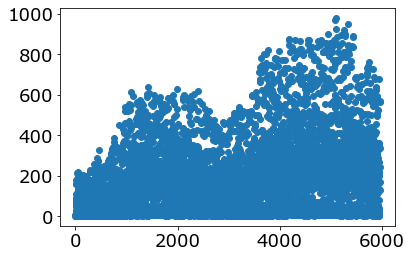

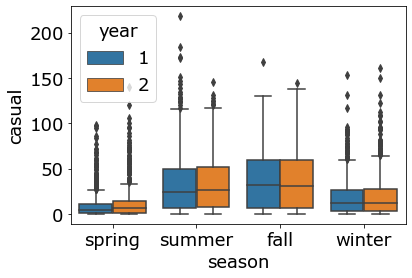

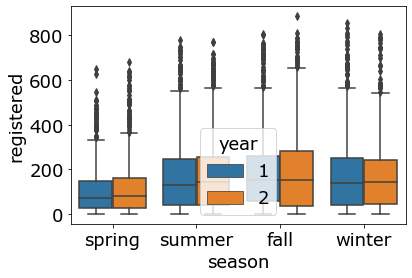

In [129]:
from collections import Counter
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import numpy as np
import os
import pandas as pd
from scipy.constants import convert_temperature
import seaborn as sns


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV,  ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVR, SVR


from pprint import pprint
import warnings



def set_fig_size(width=18,height=10):
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(width,height)
    

def set_font_size(size=18):
    font = {'family' : 'verdana',
            'size'   : size}
    rc('font', **font)
    
def make_big(f=18,w=18,h=10):
    set_font_size(size=f)
    set_fig_size(width=w,height=h)


def get_df(reset_index_and_drop=False):
    df = pd.read_csv('training_data.csv').drop(columns=['Unnamed: 0'])
    if reset_index_and_drop:
        return df.reset_index(drop=True)
    return df

df = get_df()

def get_dd():
    df = pd.read_csv('training_data.csv').drop(columns=['Unnamed: 0'])
    dd = df.drop(columns='atemp')

    df = df.sort_values(by='datetime').reset_index(drop=True)
    new_cols = list(df.columns[1:])+[df.columns[0]]
    dd = df[new_cols]
    return dd

dd = get_dd()


def do_little_eda():
    df=get_df()
    print(df.corr())

    set_font_size(size=10)
    set_font_size(size=18)

    set_fig_size()
    dd = df.drop(columns='atemp')

    sns.heatmap(dd.corr(), annot=True, cmap='coolwarm')

    corr = df.corr()
    set_fig_size()
    set_font_size()
    sns.heatmap(corr[['atemp','temp']], annot=True, cmap='coolwarm')
    plt.show()

    make_big()
    sns.boxplot(x='atemp', y='temp', data=df)
    plt.xticks(rotation=70)

    make_big()
    sns.pairplot(df, hue='season')
    


def get_dt(dt):
    return datetime.datetime.fromisoformat(dt)



season_mapper = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

weekday_mapper = {
    0: 'monday',
    1: 'tuesday',
    2: 'wednesday',
    3: 'thurday',
    4: 'friday',
    5: 'saturday',
    6: 'sunday'
    
}

def temp_mapper(temp=None, 
                low=12, 
                high=29):

    if temp is None:
        raise ValueError(f'temp must be a number. got {temp}')

    if temp<low//2:
        return 'freezing'
    elif temp<low:
        return 'cold'
    elif temp>=high*1.33:
        return 'hades'
    elif temp <= high:
        return 'nice'
    else:
        return 'hot'
    

def get_dx_old():
    get_datetime = get_dt
    from scipy.constants import convert_temperature
    dx = dd.copy()
    dx['tempcat'] = list(map(temp_mapper, dx.temp))
    dts = df['datetime'].copy()
    dx['hour'] = dts.apply(func= lambda x: get_datetime(x).hour)
    dx['weekday'] = dts.apply(func= lambda x: get_datetime(x).weekday())
    dx['weekday'] = dx.weekday.apply(func=lambda x: weekday_mapper[x])
    dx['year'] = dts.apply(func= lambda x: (get_datetime(x).year - 2011)%2011+1)
    dx['month'] = dts.apply(func=lambda x: get_datetime(x).month )
    dx['approx_temp'] = df.temp.apply(func=lambda x: round(x,1))
    low_temp_F, high_temp_F=49,78
    dx['temp_cat'] = dx.temp.apply(func=lambda x : temp_mapper(temp=x,low=convert_temperature(low_temp_F,'f','c'),high=convert_temperature(high_temp_F,'f','c')))
    dx['season'] = dx.season.apply(func=lambda x: season_mapper[x])
    return dx

dx = get_dx_old()

# plotting helper
def format_title(**kwargs):
    return ';'.join([ f'{k}={v}' for k,v in kwargs.items() ])
    
def do_plot(x,y,hue,data=dx):
    dx_=data.copy()
    make_big()
    sns.boxplot(x=dx_[x],y=dx_[y],hue=dx_[hue])
    plt.xticks(rotation=70)
    plt.title(format_title(y=y, x=x, hue=hue))
    plt.legend(loc=4)
    plt.show()


def read_input(infile):    
    return pd.read_csv(infile).drop(columns='Unnamed: 0').sort_values(by='datetime').reset_index(drop=True)


# first stage
def process_input(infile, 
                  kind='train',
                  verbose=False):
    print('Processing:', infile, 'kind:', kind, 'filename:', infile)
                                  
    if kind not in ('train', 'test'):
        raise ValueError(f'kind must be set to either "train" or "test"; got {kind}')
        
    
    def get_dt(dt):
        return datetime.datetime.fromisoformat(dt)

    data = read_input(infile)
    dd = data.drop(columns='atemp')
    dx = dd.copy()

    # print
    dx['year'] = [ str((get_dt(x).year - 2011)%2011+1) for x in dx.datetime ]
    dx['hour'] = [ str(get_dt(x).time().hour) for x in dx.datetime ]
    dx['month'] = [ str(get_dt(x).month) for x in dx.datetime ]
    dx['hr_season'] = [ str(get_dt(dx.iloc[idx].datetime).time().hour) + ','+str(dx.iloc[idx].season) for idx in range(len(dx))]
    dx['yr_month'] = [ str(get_dt(x).year) + ','+str(get_dt(x).month) for x in dx.datetime ]
    dx['yr_season'] = [ str(get_dt(dx.iloc[idx].datetime).year) + ','+str(dd.iloc[idx].season) for idx in range(len(dx)) ]

    if verbose:
        print(dx[['datetime','year','hour','month','hr_season','yr_month','yr_season']])
        print()
        print('feature name,','number of disctint values')
        print('set of distinct values')
        print('='*80)
        for time_var in [#'datetime',
                         'season',
                         'year',
                         'hour',
                         'month',
                         'hr_season',
                         'yr_month',
                         'yr_season']:
            print()
            print(time_var,len(list(sorted(list(set(dx[time_var]))))))
            print(list(sorted(list(set(dx[time_var])))))


    dx = dx.reset_index(drop=True)

    # print('HEY!',dx.columns)
    if kind == 'train':
        y_vars = [
            'casual', 
            'registered', 
            'count']
    elif kind == 'test':
        y_vars = []

    x_continuous = [
            'temp',
            'humidity',
            'windspeed']

    drop_timevars = [
            'datetime',
            'index',
            'season',
            'year',
            'hour',
            'month']

    x_categorical = [ col for col in dx.columns if col not in y_vars+x_continuous+drop_timevars ] 

    if verbose:
        print('Y:', y_vars)
        print('X_cont:', x_continuous)
        print('X_cat:', x_categorical)
        print('All:', dx.columns)

    d_y = dx[y_vars]
    d_xcat = dx[x_categorical]
    d_xcont = dx[x_continuous]

    
    print('kind:', kind)
    if kind == 'train':
        verbose and print('return d_y, d_xcat, d_xcont')
        return d_y, d_xcat, d_xcont
    else:
        verbose and print('return d_xcat, d_xcont')
        return d_xcat, d_xcont

# helper
def copy_columns(to_=None, from_=None):
    
    _to, _from= to_.copy(),from_.copy()
    
    if to_ is None:
        raise ValueError(f'Set to_ to a destination DataFrame. Got {to_}')
    elif from_ is None:
        raise ValueError(f'Set from_ to a source DataFrame. Got {from_}')
    
    for colname in from_.columns:
        _to[colname] = from_[colname]
        
    return _to


# preprocessors
def get_vectorized(data,
                   sparse=False,
                   filter_data=False):
    if filter_data:
        data = data[filter_data]
        
    v = DictVectorizer(sparse=sparse)
    return v, v.fit_transform(data.to_dict('records'))
def get_dict_vectorized(data, sparse=False, filter_data=False):
    if filter_data:
        data = data[filter_data]
    return DictVectorizer(sparse=sparse).fit_transform(data.to_dict('records'))

def get_minmax_scaled(data:pd.DataFrame):
    data = data.copy()
    scaler = MinMaxScaler()
    return scaler, pd.DataFrame(columns = data.columns,
                 data = scaler.fit_transform(data.to_numpy()))





def get_dummies(data, drop_first=False, filter_data=False):
    if filter_data:
        data = data[filter_data]
    return pd.get_dummies(data, drop_first=drop_first)




def get_x_train(infile='training_data.csv'):
    '''
    def get_x_train(inp='training_data.csv')->np.array
    '''
    train_y, train_xcat, train_xcont = process_input(infile=infile,
                                                     kind='train')
    vectorizer,xvectorized = get_vectorized(train_xcat)
    scaler, xscaled = get_minmax_scaled(data=train_xcont)
    return np.concatenate((xvectorized, xscaled), 
                          axis=1)

def get_x_test(infile='test_data.csv'):
    test_xcat, test_xcont = process_input('test_data.csv',
                                      kind='test')
    vectorizer,xvectorized = get_vectorized(test_xcat)
    scaler, xscaled = get_minmax_scaled(data=test_xcont)
    return np.concatenate((xvectorized, xscaled), 
                          axis=1)
    

def get_y_train(infile='training_data.csv',
                minmaxscale=False):
    
    train_y, train_xcat, train_xcont = process_input(infile=infile,
                                                     kind='train')
    return train_y


def get_train_test_split(minmax_y=False):
    
    X_TRAIN = get_x_train()
    Y_TRAIN = get_y_train()
    print(X_TRAIN.shape)
    print(Y_TRAIN.shape)

    X_TEST = get_x_test()
    print(X_TEST.shape)

    if minmax_y:
        yscaler, y = get_minmax_scaled(Y_TRAIN)
    else:
        y_scaler, y = None, Y_TRAIN
    X = X_TRAIN
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if minmax_y:
        return X_train, X_test, y_train, y_test, y_scaler
    
    return X_train, X_test, y_train, y_test



hues = ['hour','temp_cat','weekday','month']
xs = ['workingday',
      'weekday',
      'temp_cat',
      'temp',
      #'month',
      'holiday',
      'temp_cat']



plots = []


for h in hues:
    for x in xs:
        for y in ['casual', 'registered']:
            if h==x:
                continue
            this = {
                'y':y,
                'x':x,
                'hue':h}
            plots.append(this)
            

for i, plot in enumerate(plots):
    print(plot)
 #   do_plot(**plots[i])
    
    
d = dx[dx.workingday==1]

plt.scatter(range(len(d.index)), d['count'])
plt.show()

# plt.hist(d.temp_cat)
# plt.title('temp categories')

for yy in ['casual','registered']:
    sns.boxplot(y=yy,x='season', hue='year', data=dx[dx.workingday==1])
    plt.show()

# sns.boxplot(y='count',x='workingday',data=dd)
# plt.show()


from scipy.constants import convert_temperature

def get_datetime(x):
    return datetime.datetime.fromisoformat(x)


season_mapper = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

weekday_mapper = {
    0: 'monday',
    1: 'tuesday',
    2: 'wednesday',
    3: 'thurday',
    4: 'friday',
    5: 'saturday',
    6: 'sunday'
    
}


    
def temp_mapper(temp=None, 
                low=12, 
                high=29):

    if temp is None:
        raise ValueError(f'temp must be a number. got {temp}')

    if temp<low//2:
        return 'freezing'
    elif temp<low:
        return 'cold'
    elif temp>=high*1.33:
        return 'hades'
    elif temp <= high:
        return 'nice'
    else:
        return 'hot'
    
# dx['season'] = [ season_mapper[s] for s in dx.season ]
# dx['year'] = [ str((get_dt(x).year - 2011)%2011+1) for x in dx.datetime ]
# dx['hour'] = [ str(get_dt(x).time().hour) for x in dx.datetime ]
# dx['month'] = [ str(get_dt(x).month) for x in dx.datetime ]
# dx['tempcat'] = list(map(temp_mapper, dx.temp))

# making cyclic time variables hour, weekday, year, month


### quick EDA of data
- results only
- demonstraing correlations of note
- more info in `eda*.ipynb`

              season   holiday  workingday   weather      temp     atemp  \
season      1.000000  0.023694   -0.006080  0.015364  0.253267  0.260547   
holiday     0.023694  1.000000   -0.254820 -0.010776  0.002996 -0.002293   
workingday -0.006080 -0.254820    1.000000  0.040086  0.029400  0.024527   
weather     0.015364 -0.010776    0.040086  1.000000 -0.052387 -0.052974   
temp        0.253267  0.002996    0.029400 -0.052387  1.000000  0.985248   
atemp       0.260547 -0.002293    0.024527 -0.052974  0.985248  1.000000   
humidity    0.198741  0.001392   -0.003860  0.412188 -0.062023 -0.041475   
windspeed  -0.156544  0.003474    0.007291  0.008978 -0.026653 -0.065143   
casual      0.092786  0.049245   -0.324122 -0.139385  0.470176  0.465651   
registered  0.160494 -0.022615    0.113787 -0.109506  0.323658  0.318756   
count       0.159331 -0.005169    0.004835 -0.129810  0.399809  0.394473   

            humidity  windspeed    casual  registered     count  
season      0.198741 

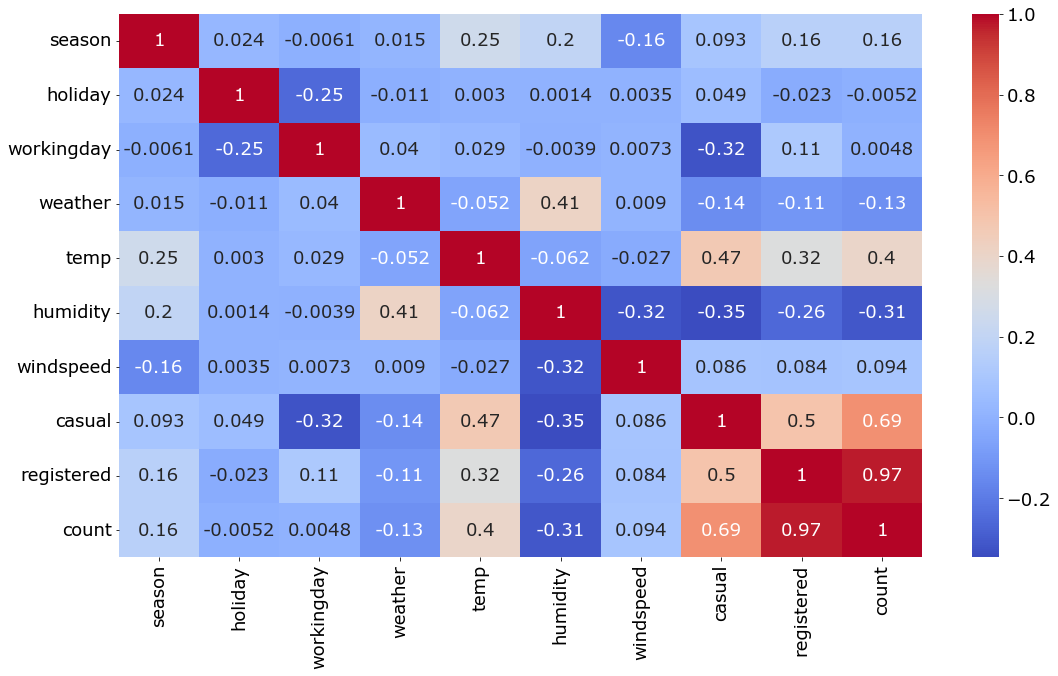

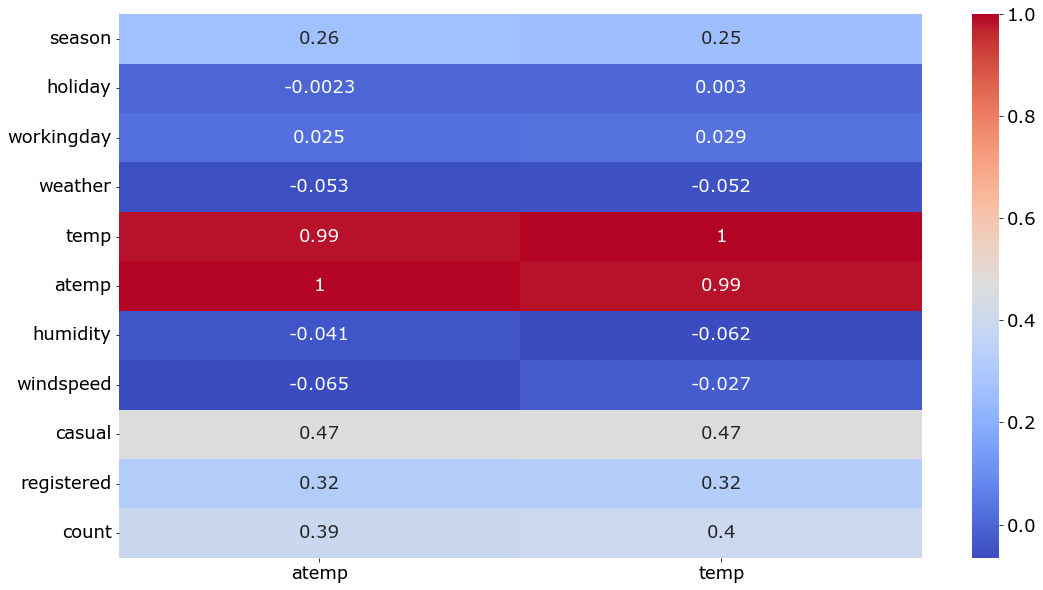

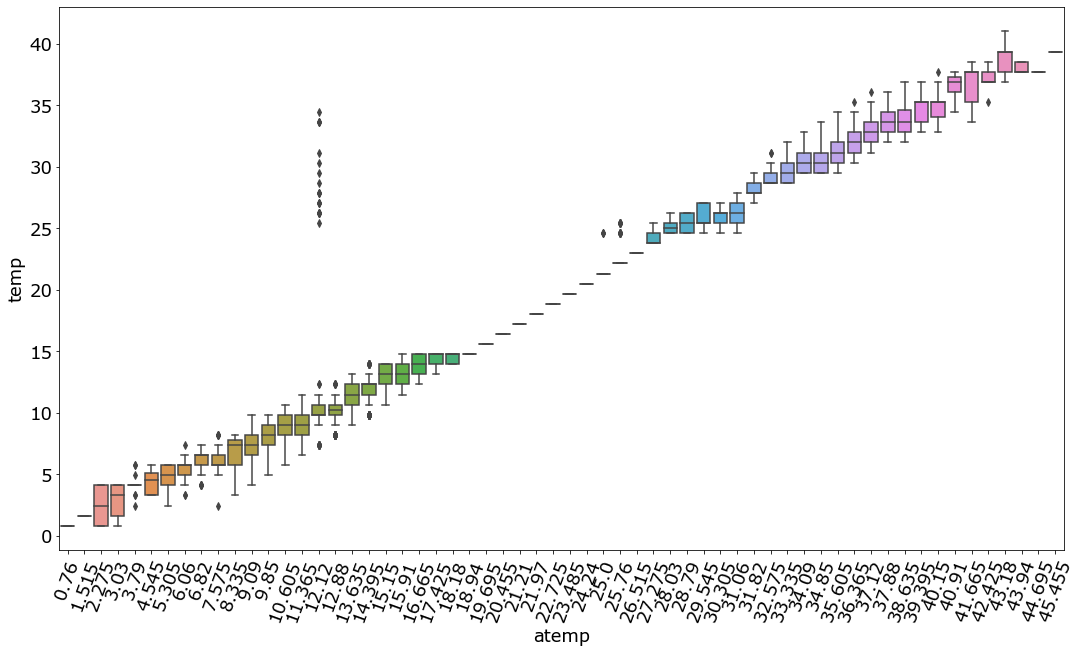

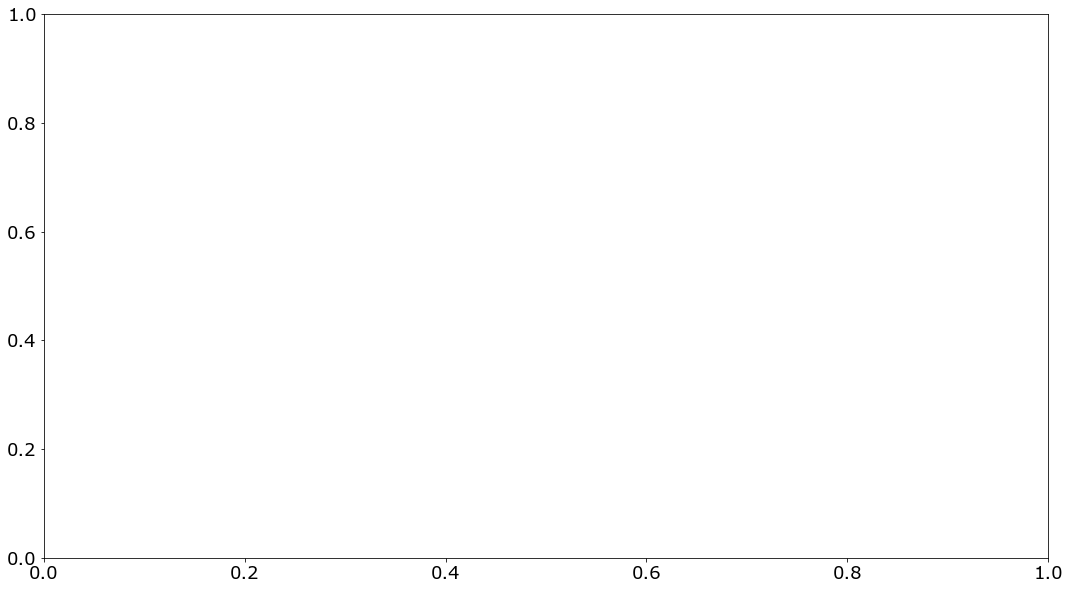

In [ ]:
do_little_eda()

### more EDA, investigating interactions of categories with with cyclic time 

Plotting...
[{'hue': 'hour', 'x': 'workingday', 'y': 'casual'},
 {'hue': 'hour', 'x': 'workingday', 'y': 'registered'},
 {'hue': 'hour', 'x': 'weekday', 'y': 'casual'},
 {'hue': 'hour', 'x': 'weekday', 'y': 'registered'},
 {'hue': 'hour', 'x': 'temp_cat', 'y': 'casual'},
 {'hue': 'hour', 'x': 'temp_cat', 'y': 'registered'},
 {'hue': 'hour', 'x': 'month', 'y': 'casual'},
 {'hue': 'hour', 'x': 'month', 'y': 'registered'},
 {'hue': 'hour', 'x': 'holiday', 'y': 'casual'},
 {'hue': 'hour', 'x': 'holiday', 'y': 'registered'},
 {'hue': 'hour', 'x': 'temp_cat', 'y': 'casual'},
 {'hue': 'hour', 'x': 'temp_cat', 'y': 'registered'},
 {'hue': 'temp_cat', 'x': 'workingday', 'y': 'casual'},
 {'hue': 'temp_cat', 'x': 'workingday', 'y': 'registered'},
 {'hue': 'temp_cat', 'x': 'weekday', 'y': 'casual'},
 {'hue': 'temp_cat', 'x': 'weekday', 'y': 'registered'},
 {'hue': 'temp_cat', 'x': 'month', 'y': 'casual'},
 {'hue': 'temp_cat', 'x': 'month', 'y': 'registered'},
 {'hue': 'temp_cat', 'x': 'holiday', '

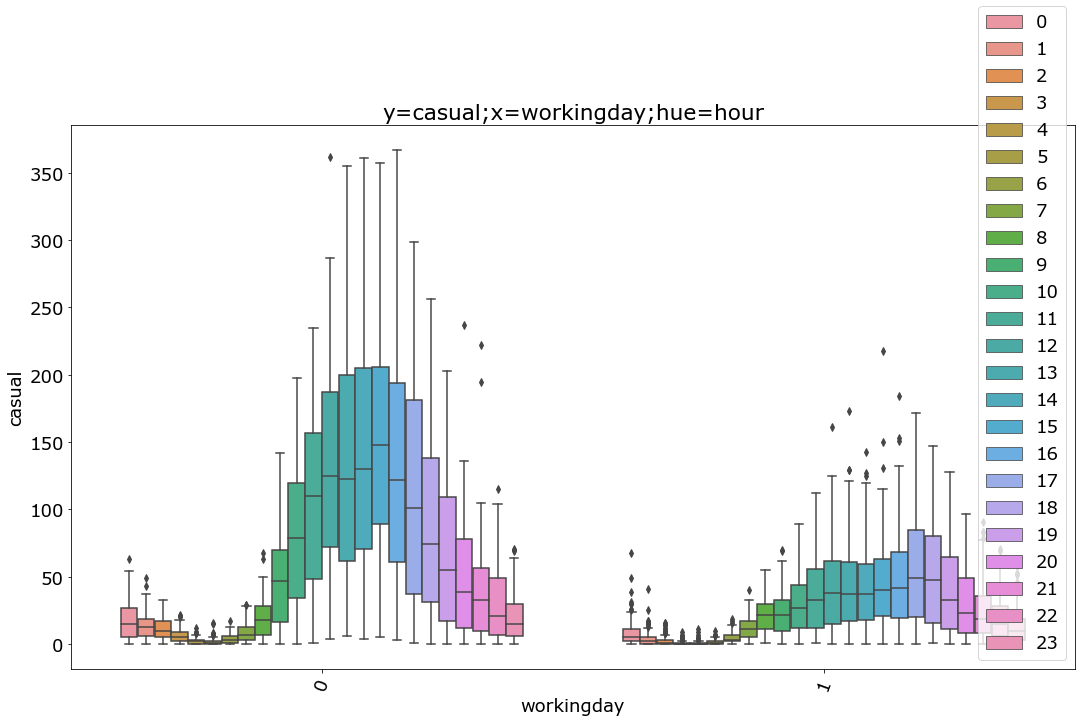

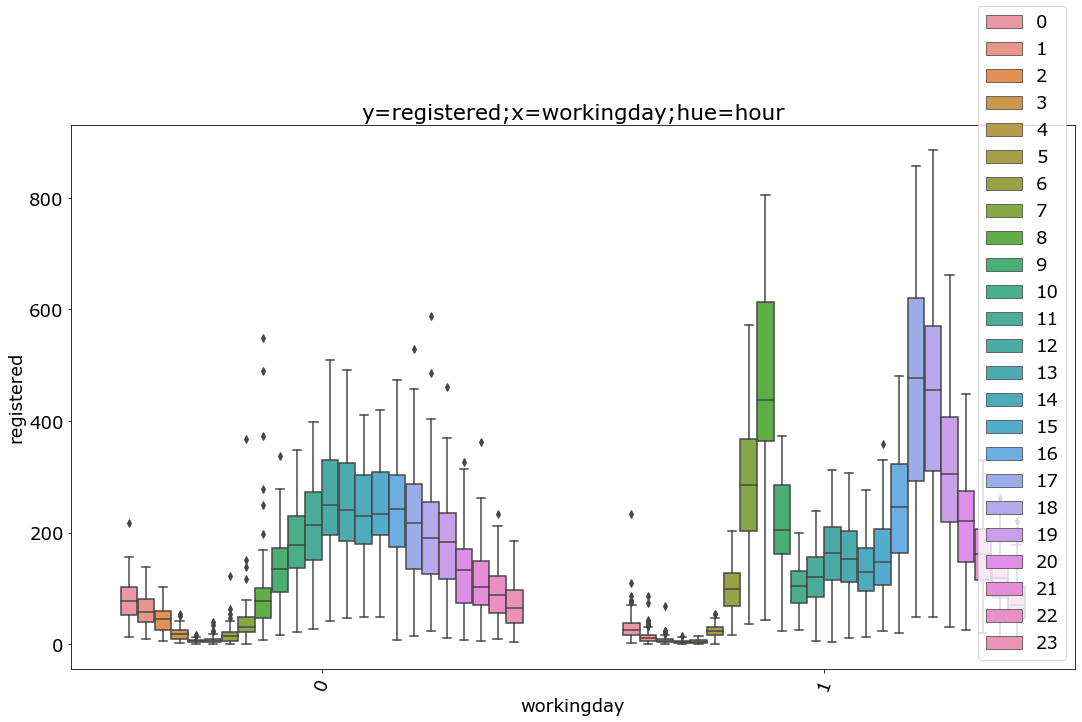

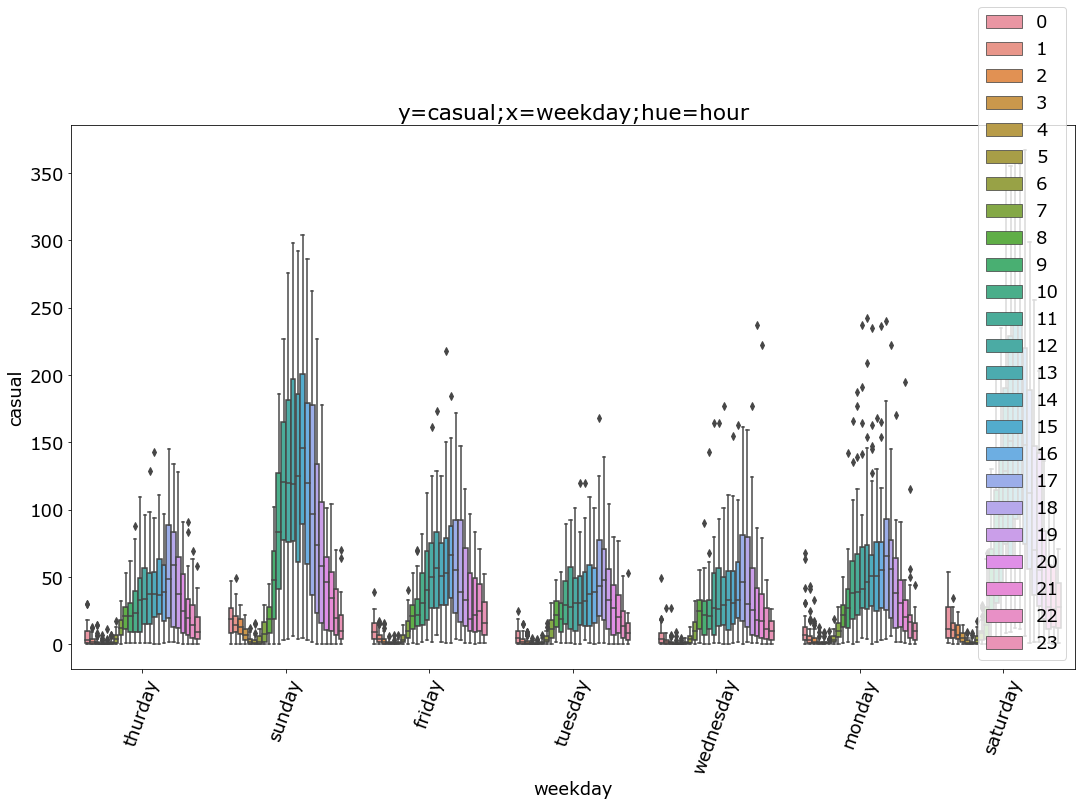

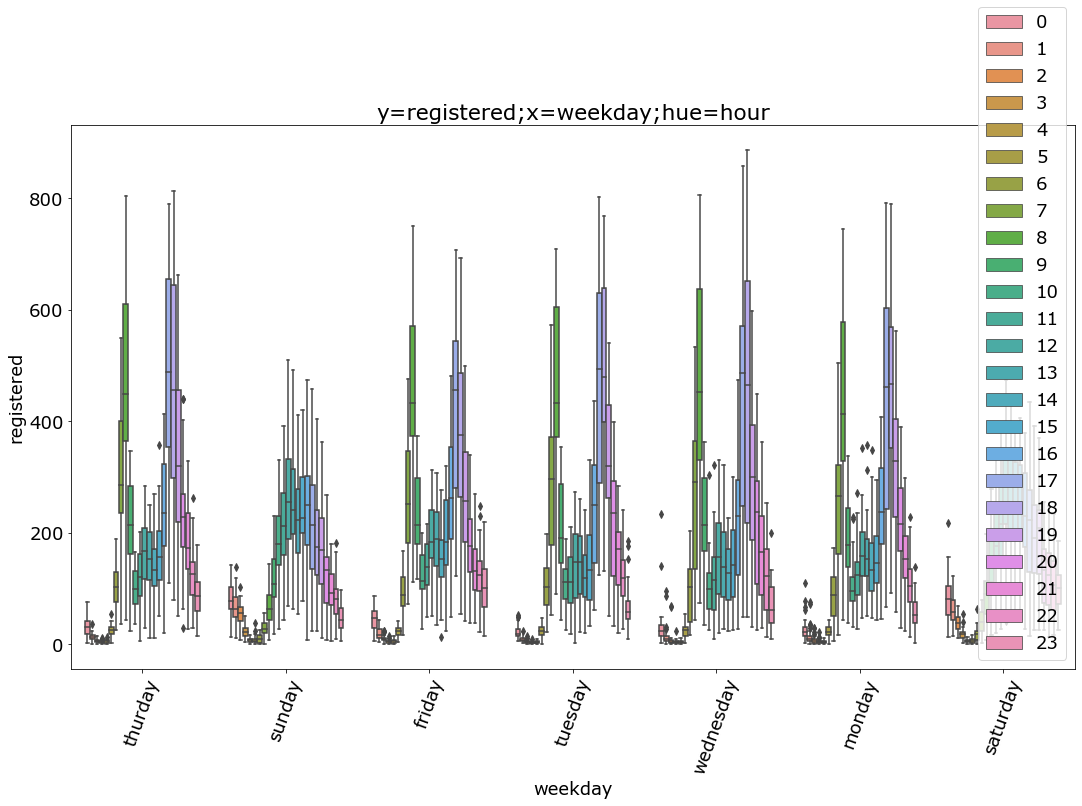

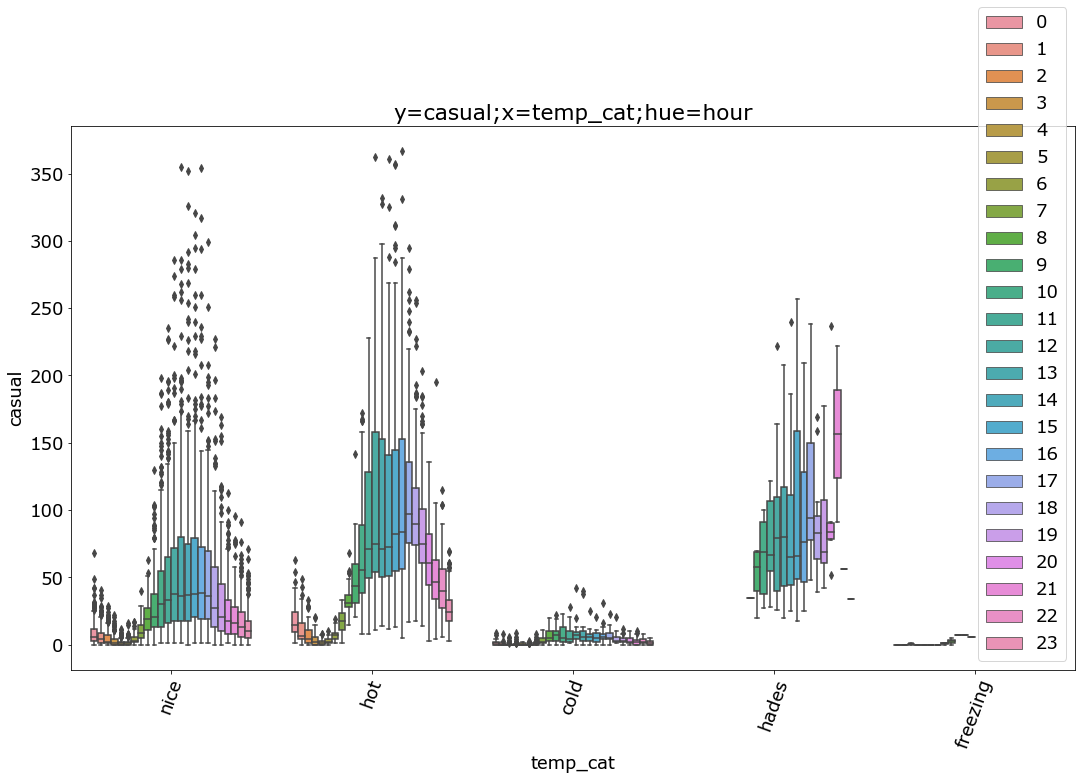

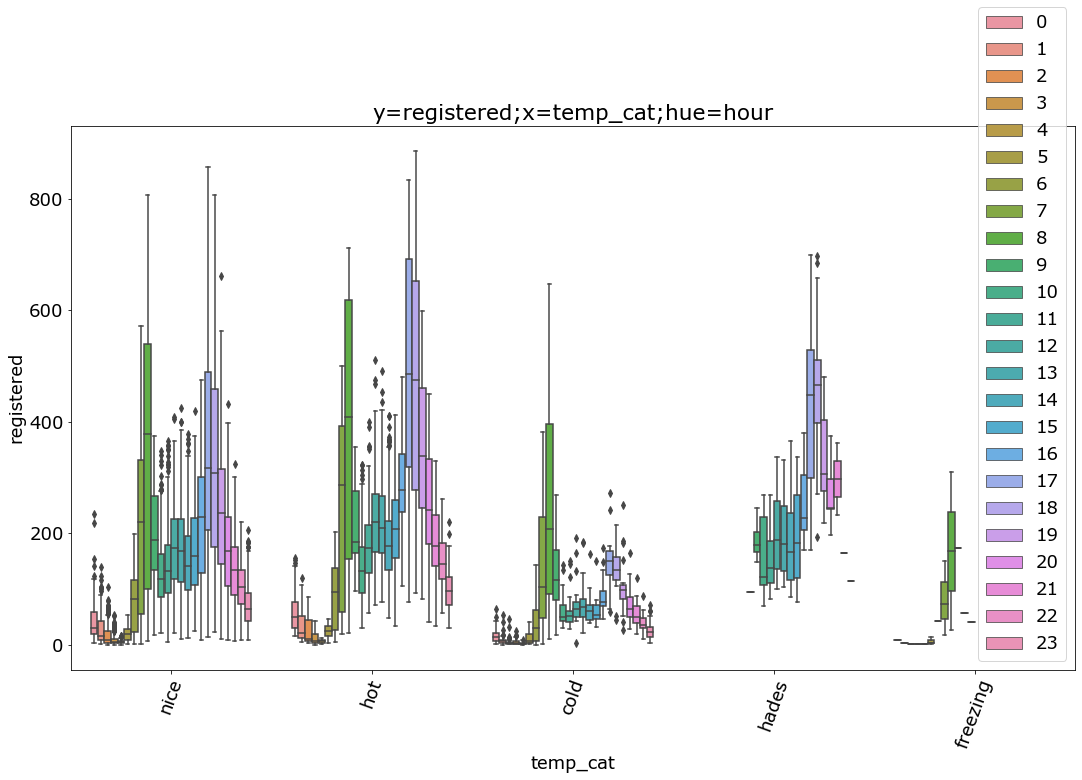

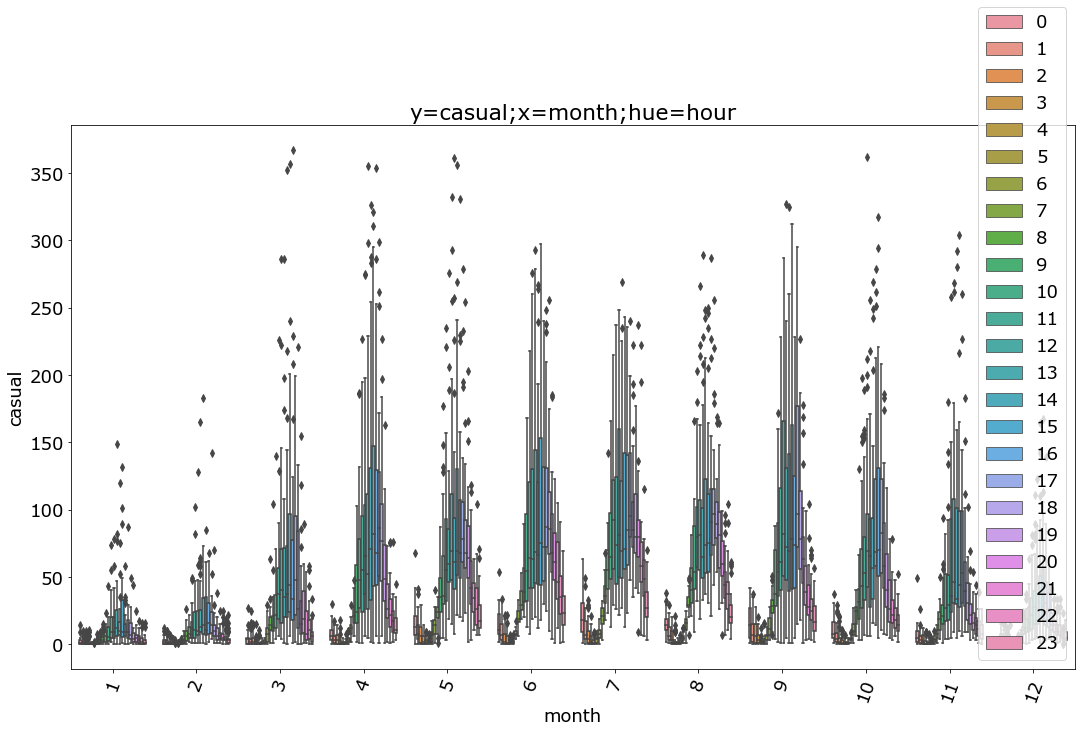

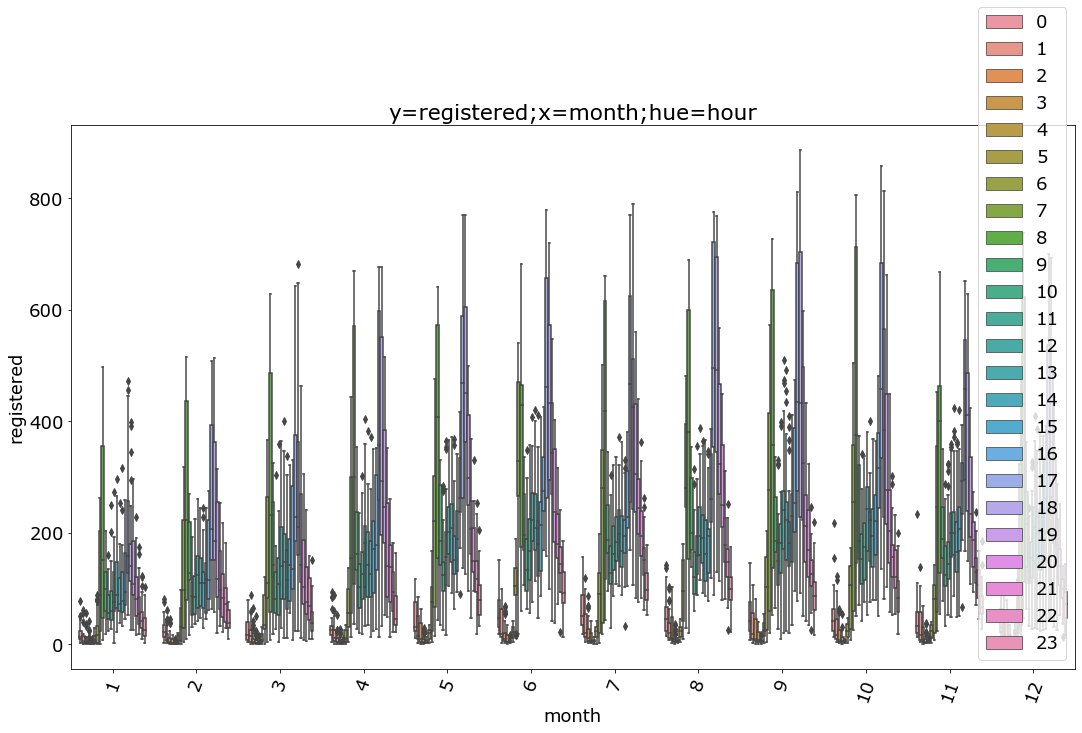

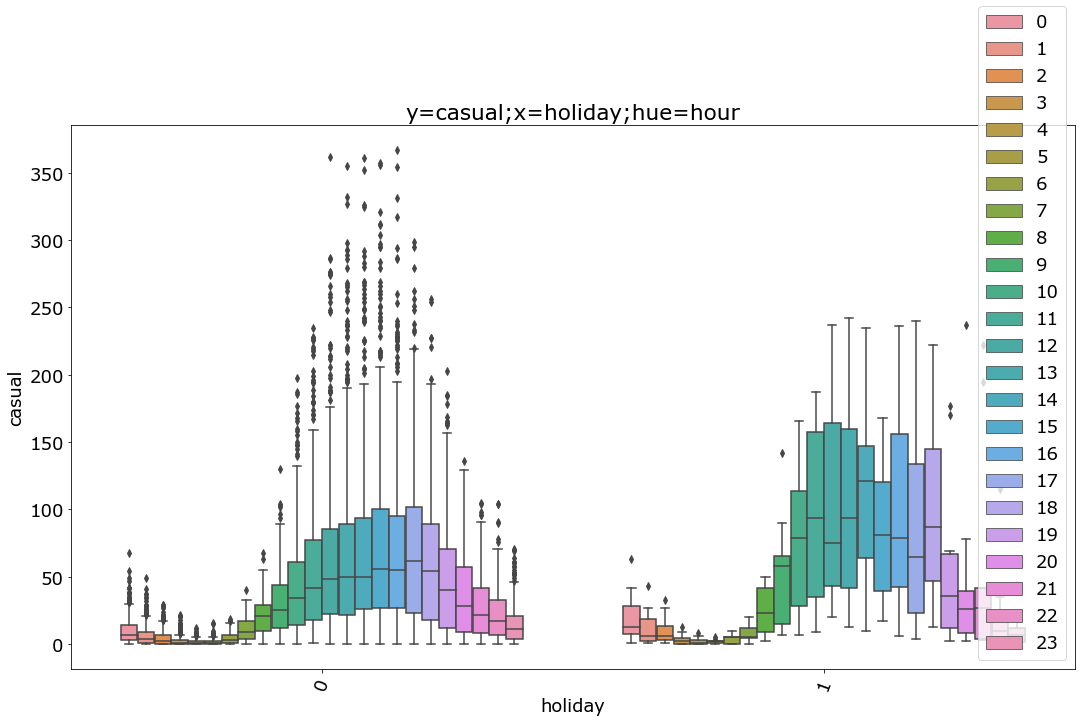

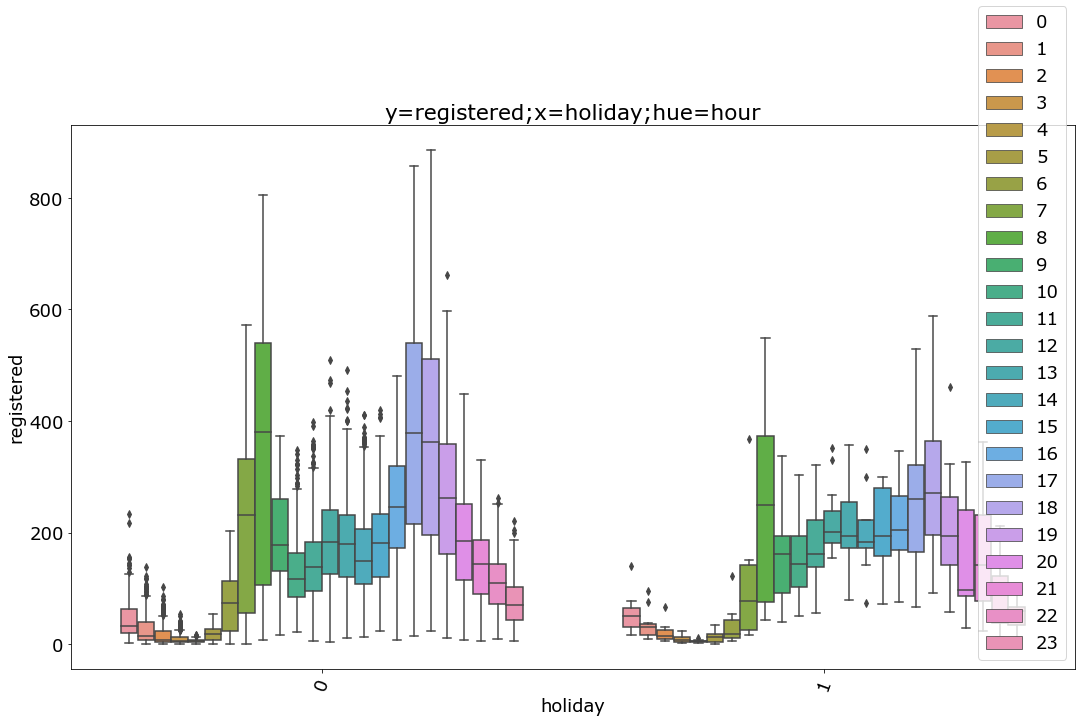

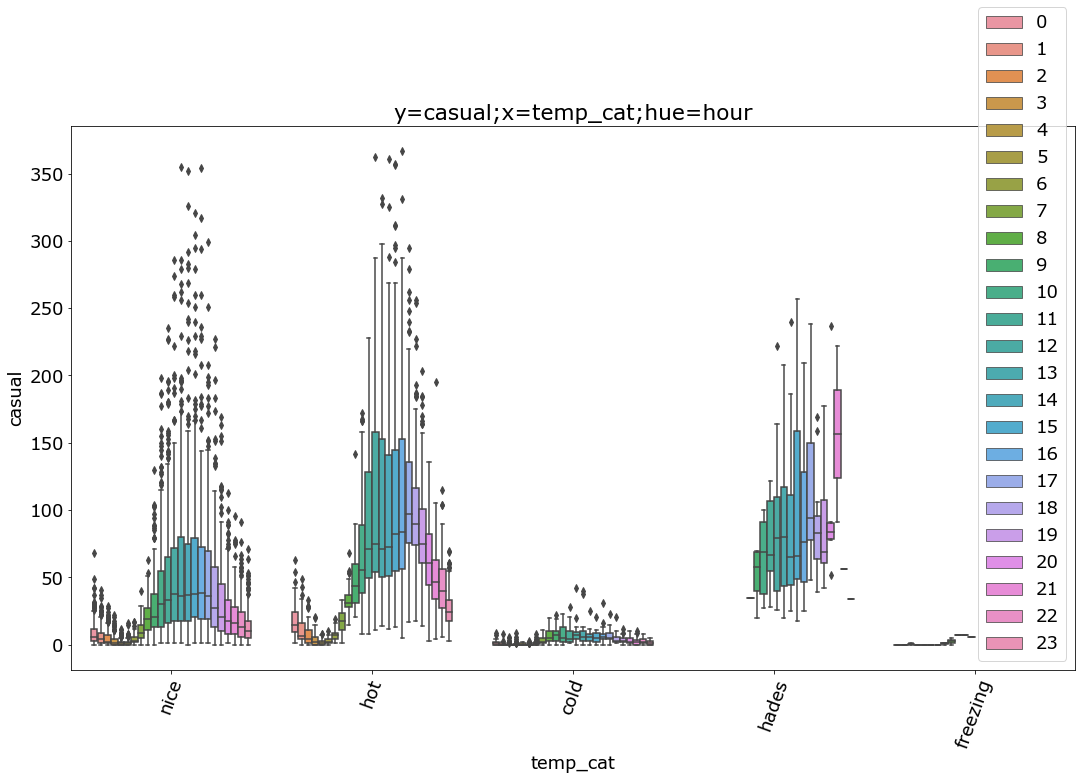

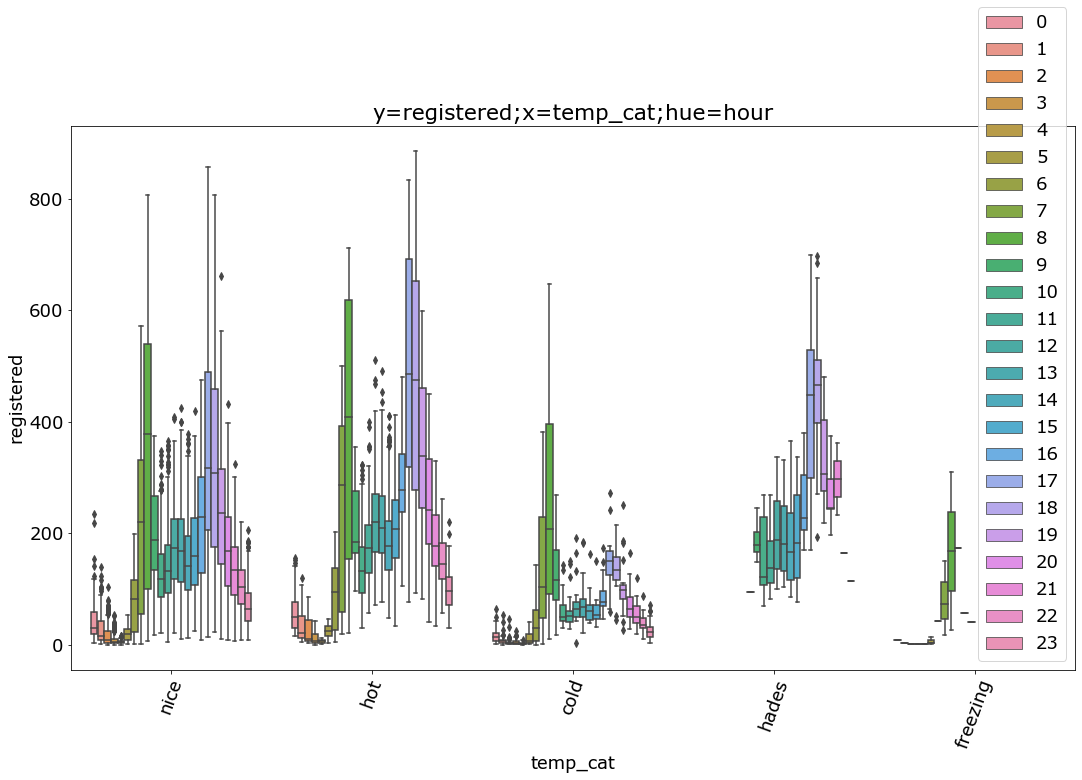

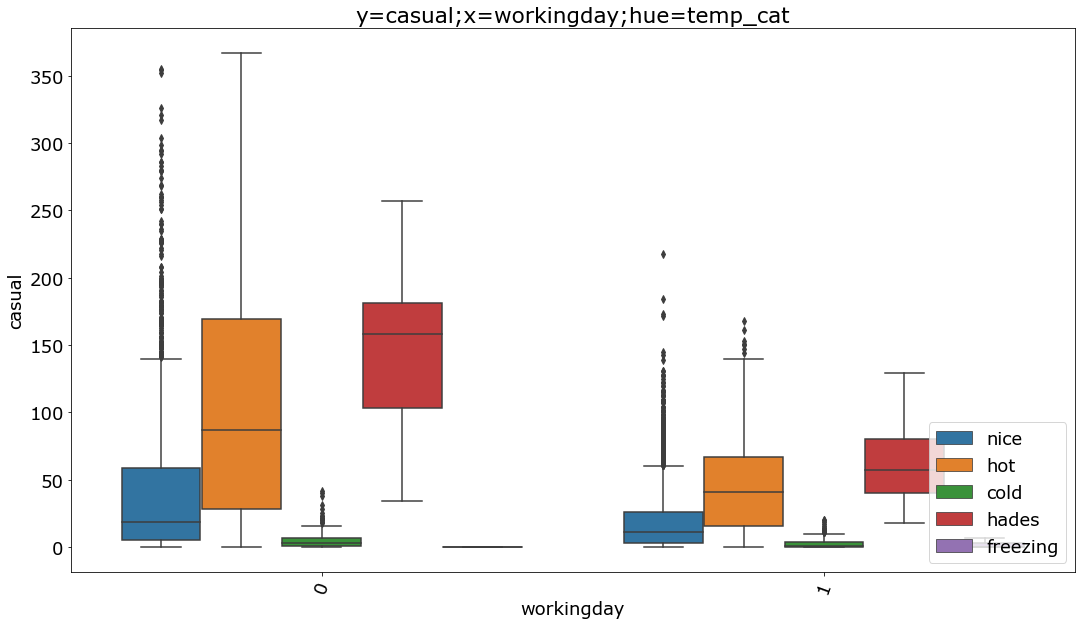

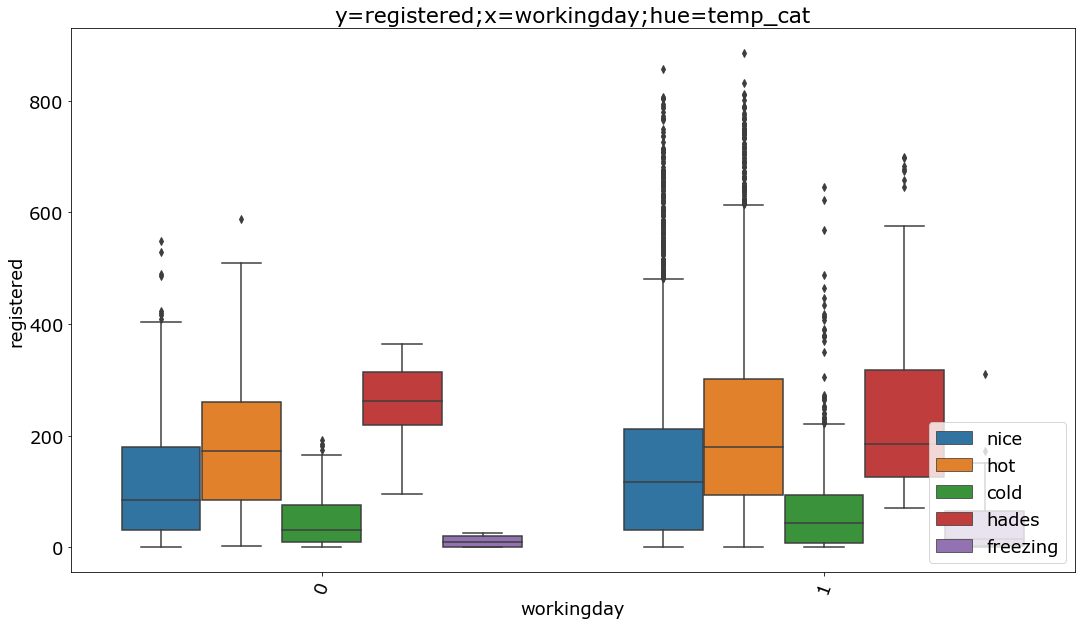

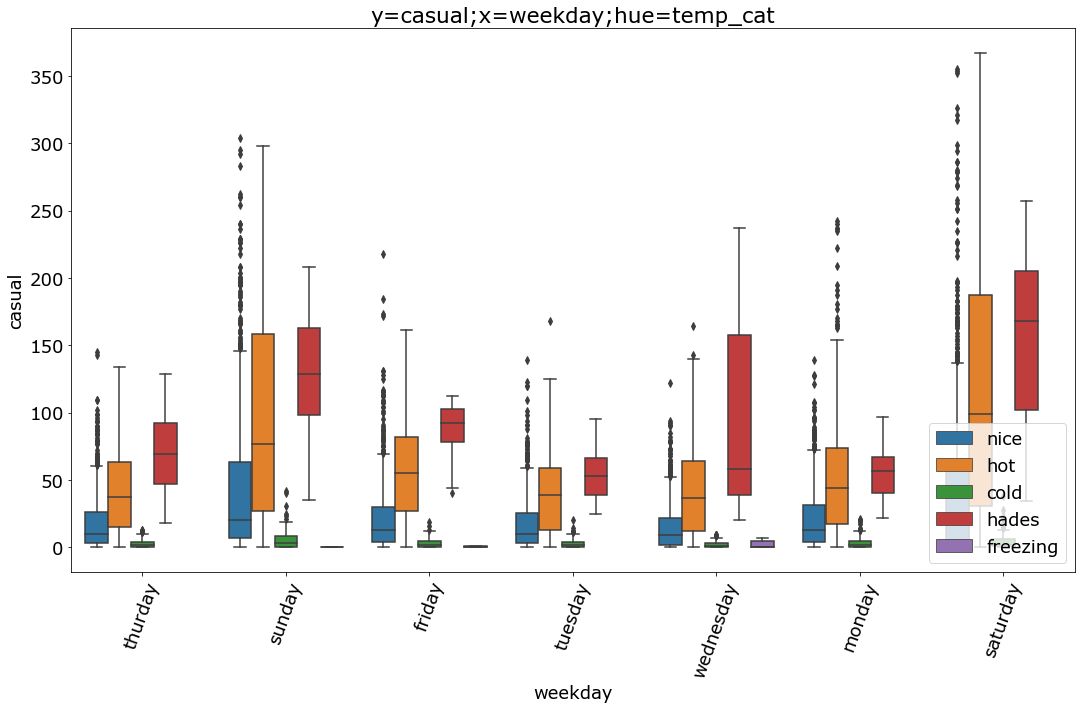

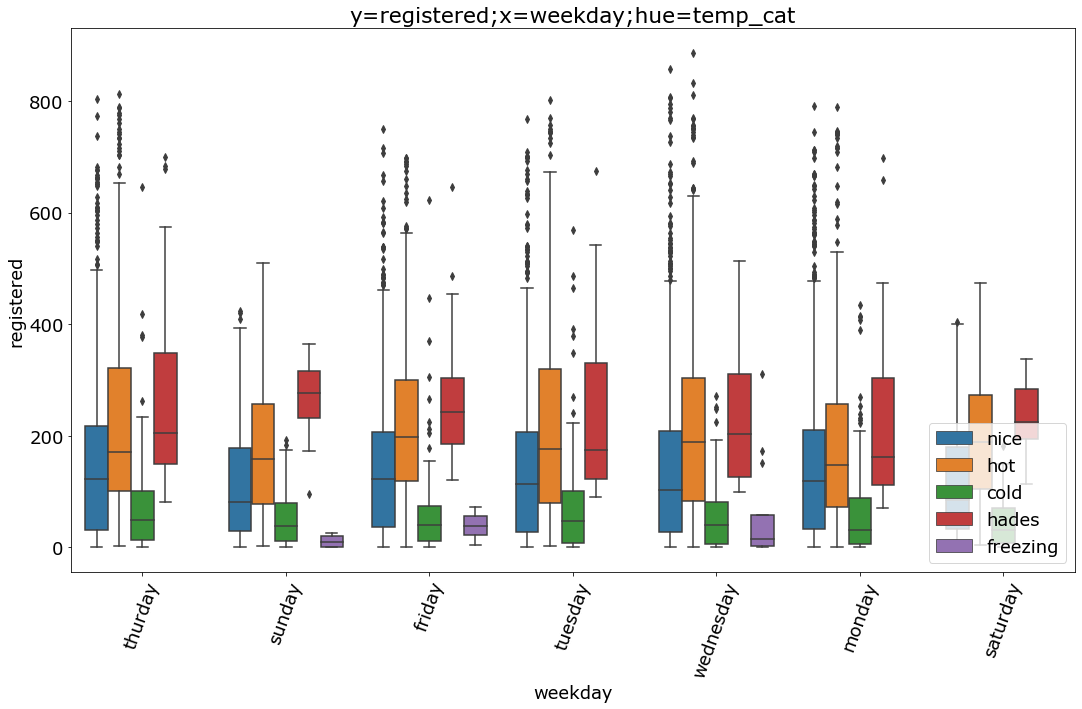

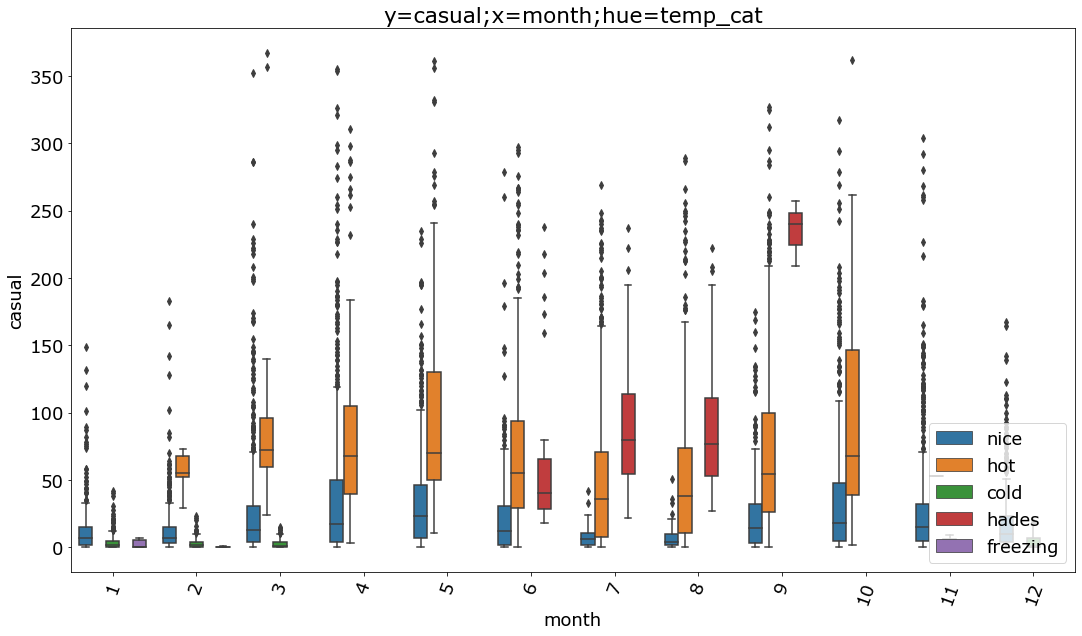

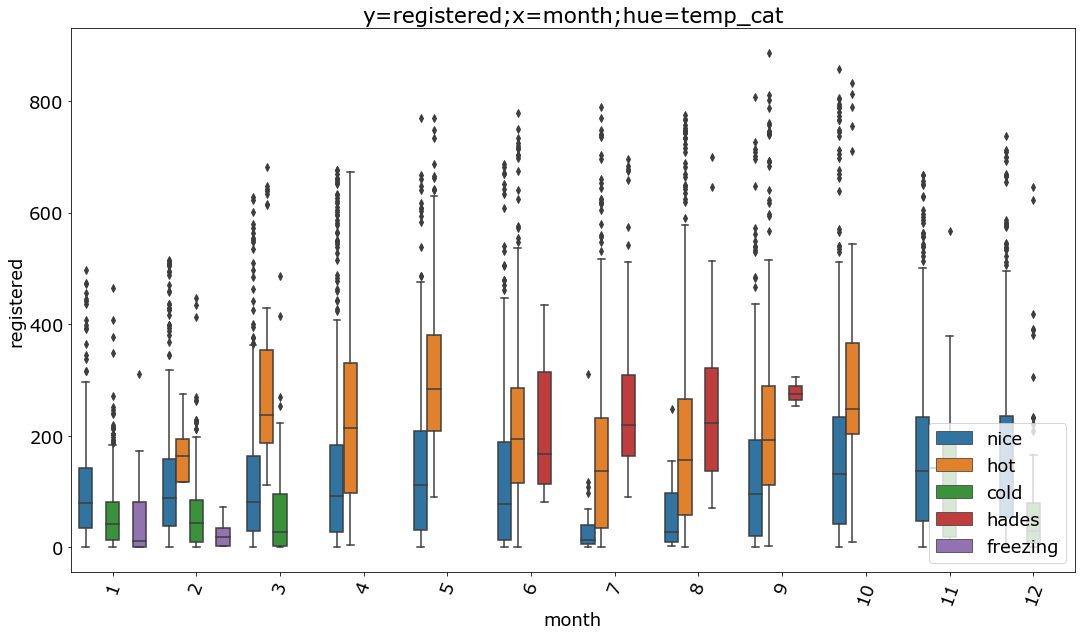

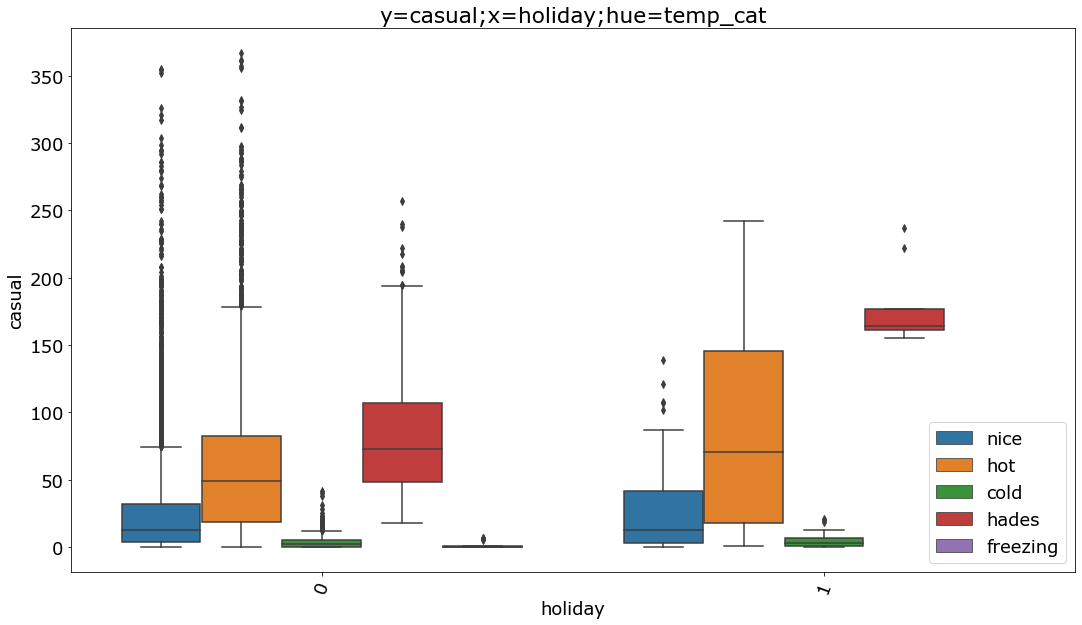

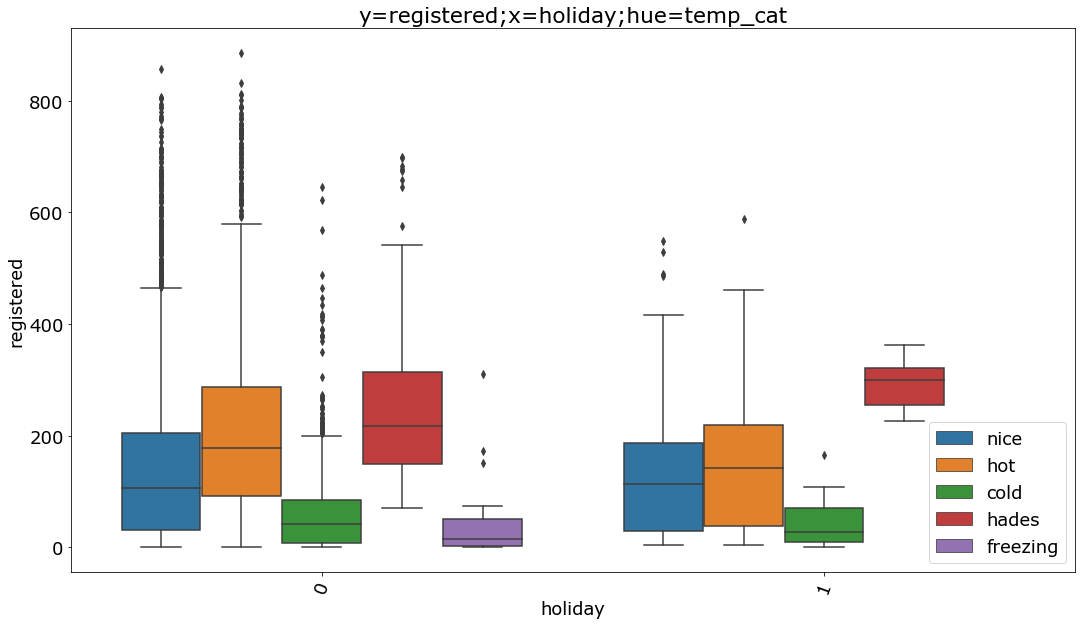

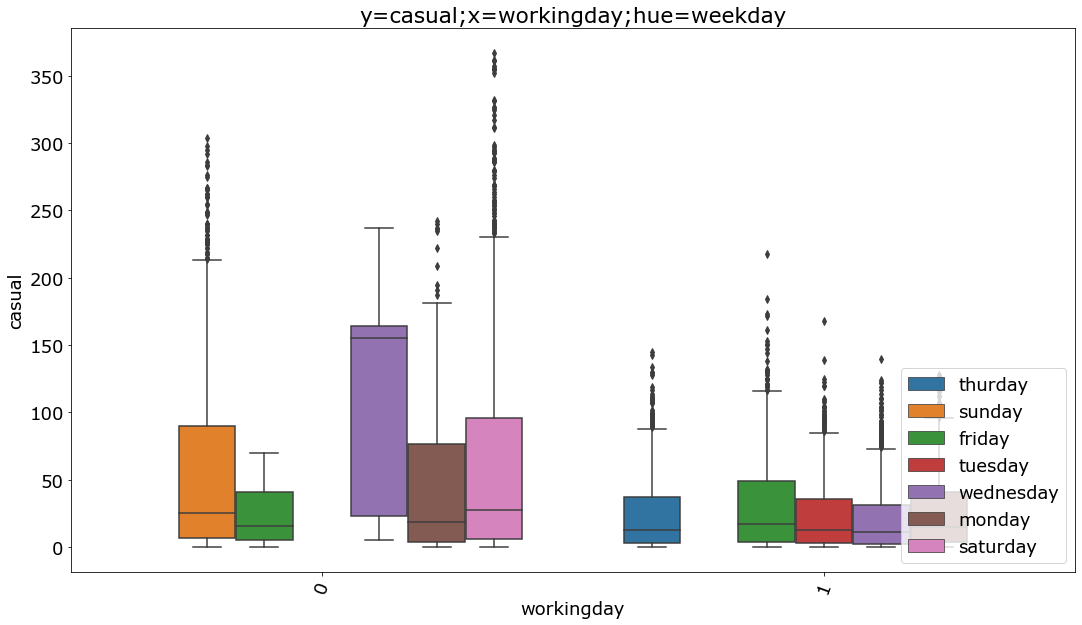

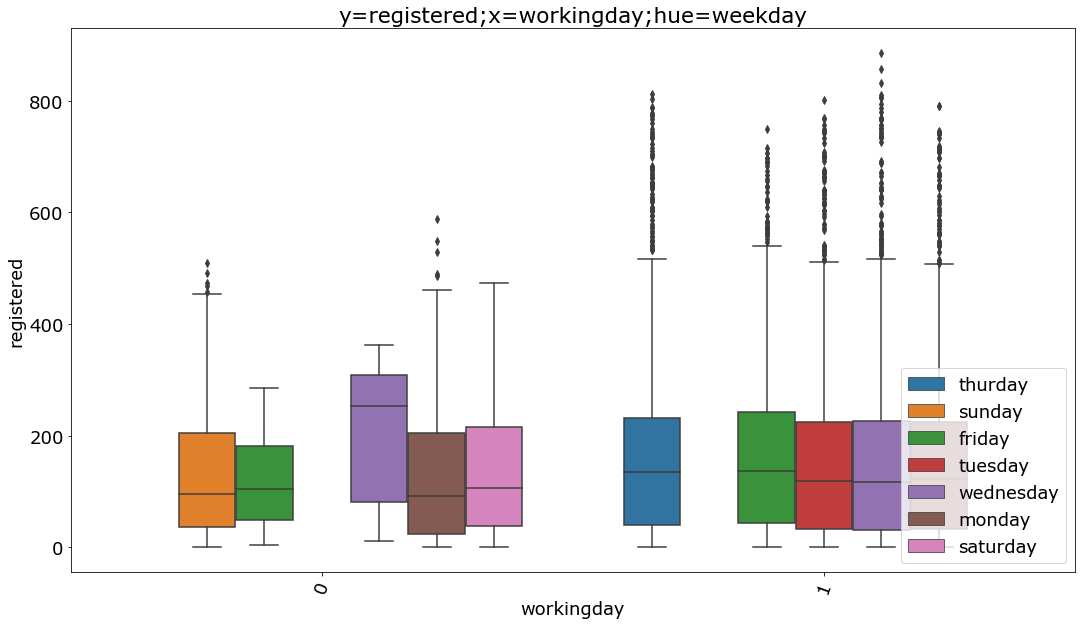

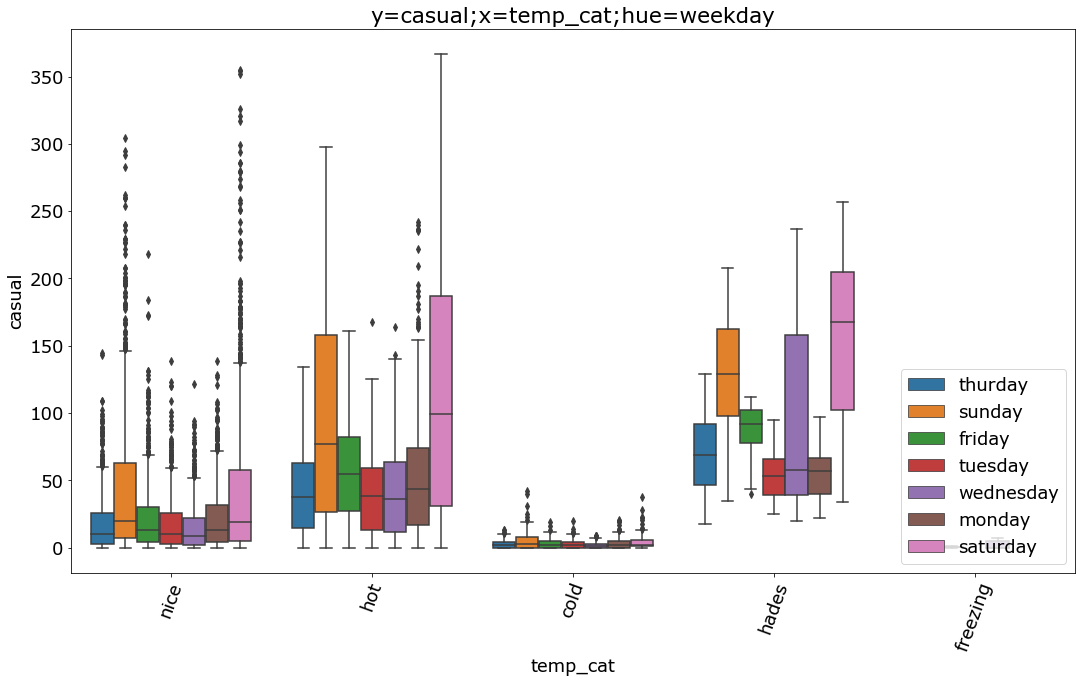

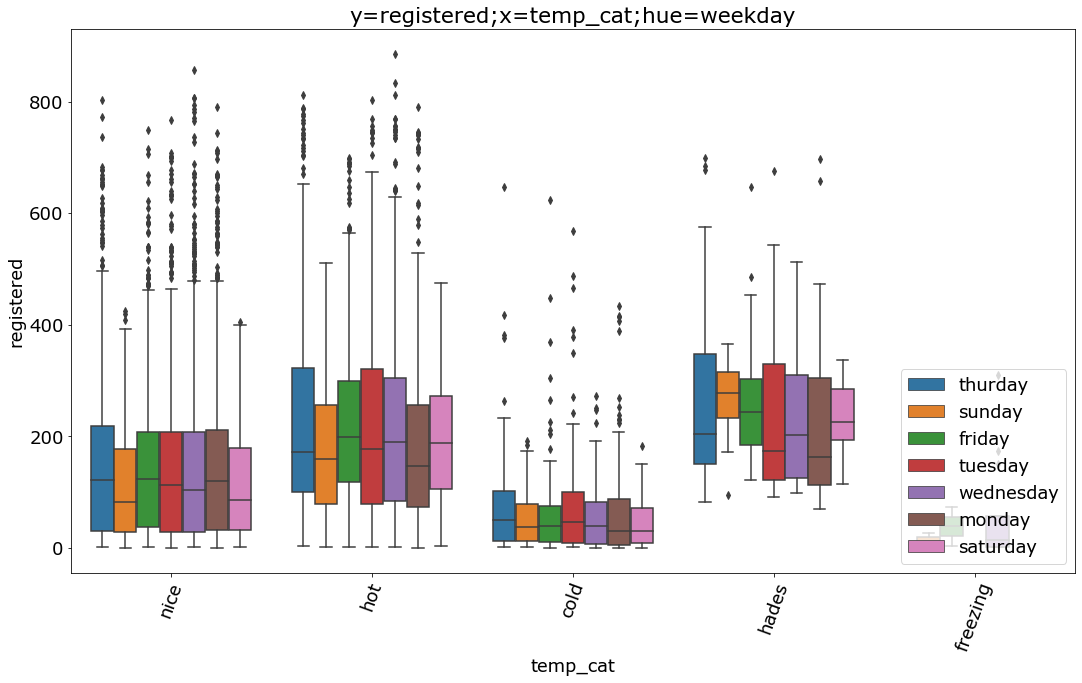

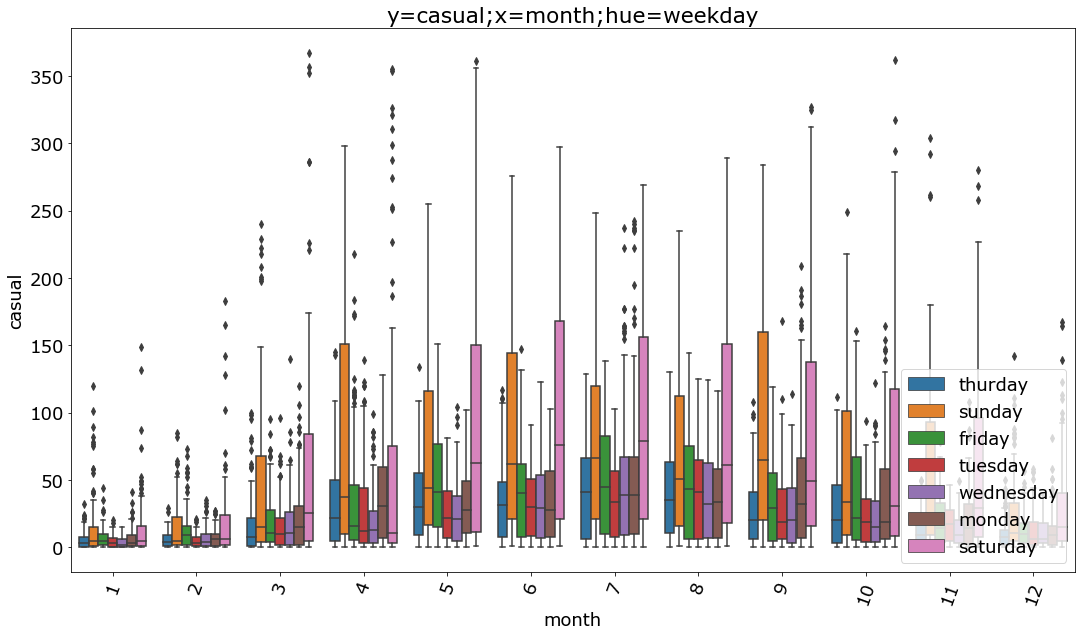

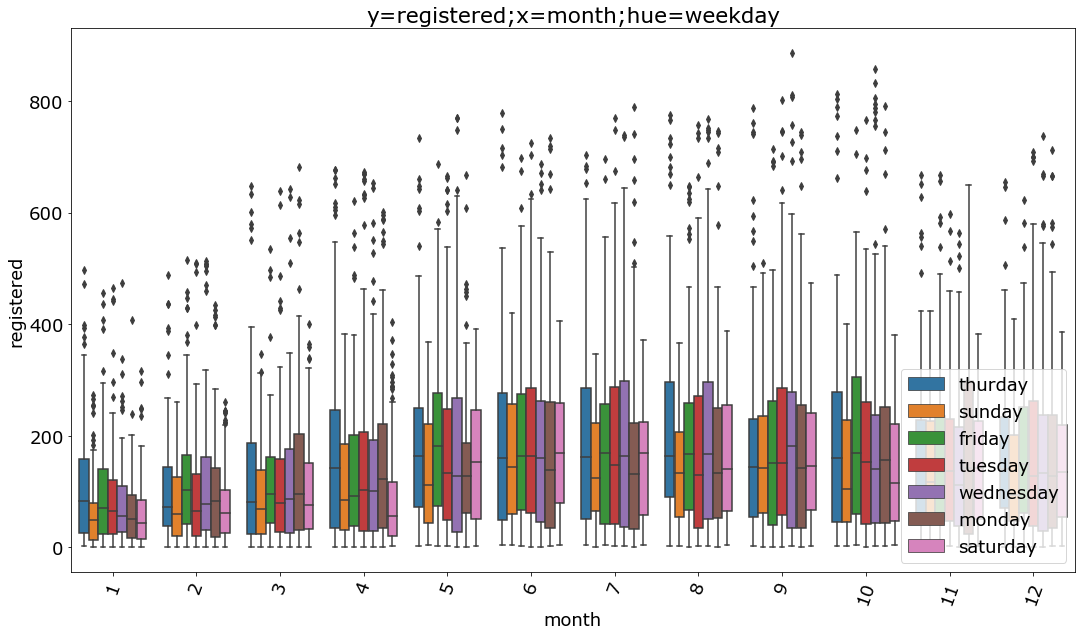

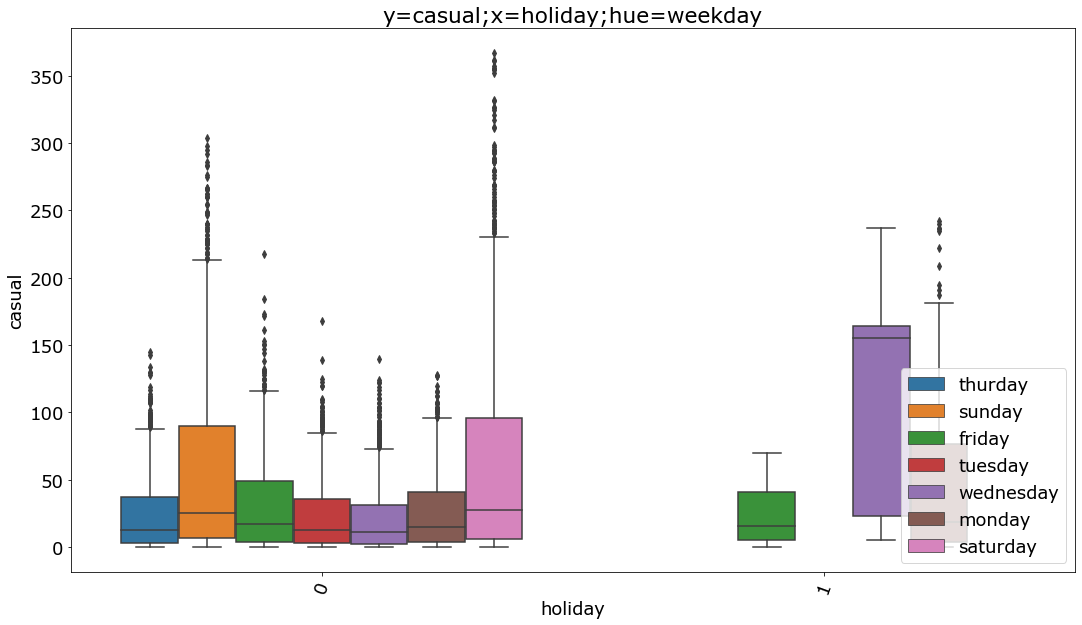

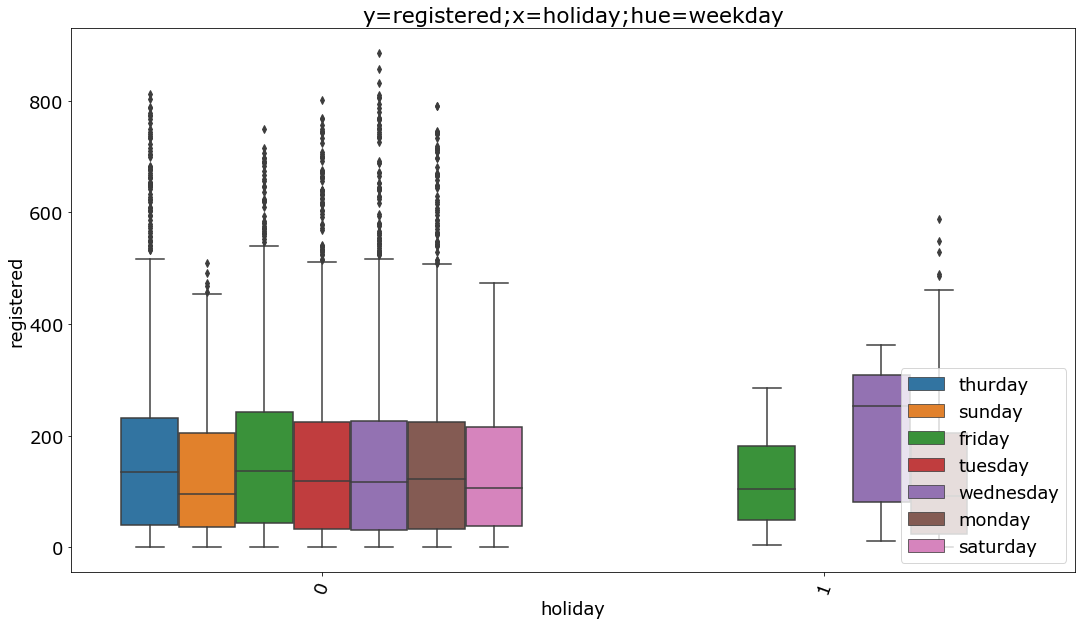

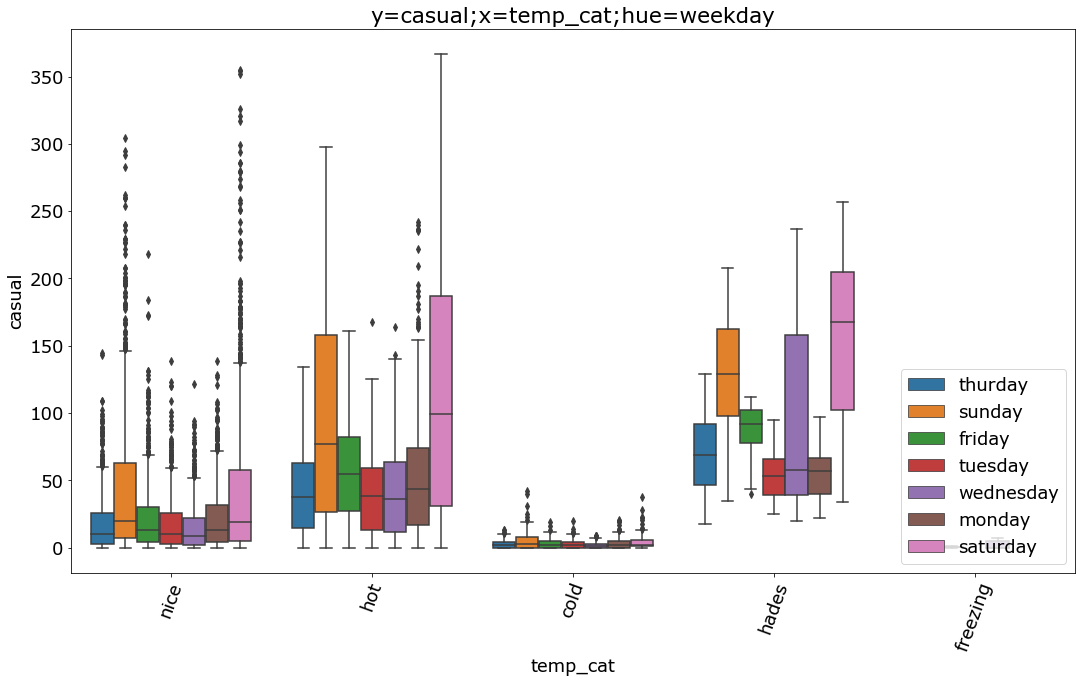

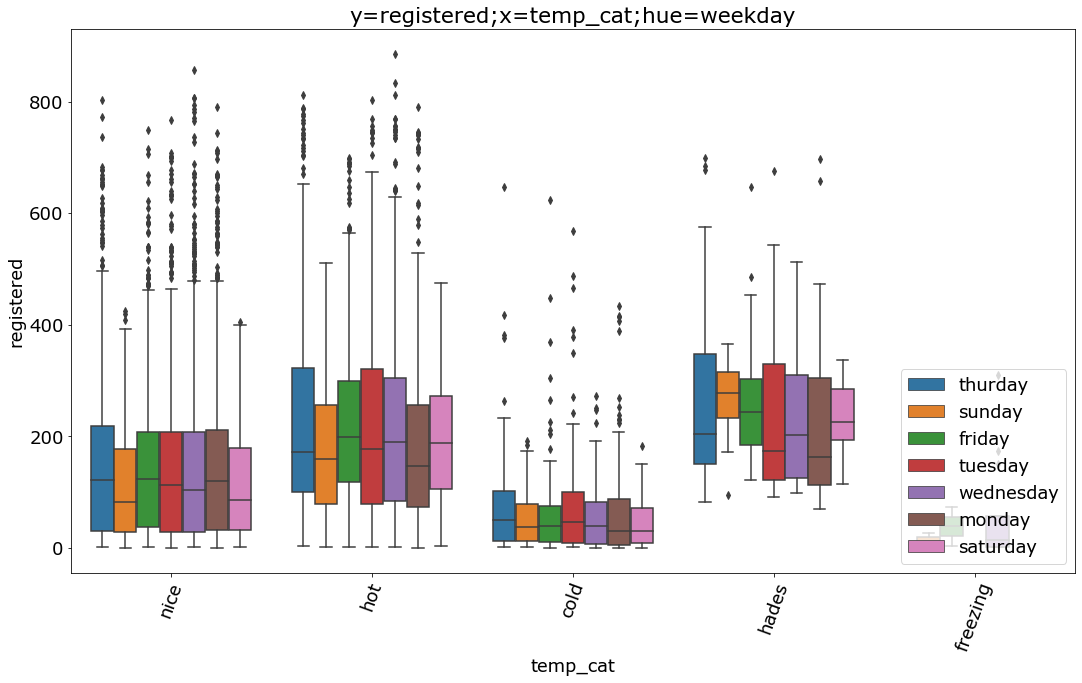

                 datetime  year  hour  month  hr_season yr_month    yr_season  \
0     2011-01-01 00:00:00     2    16      4   0,spring   2011,1  2011,spring   
1     2011-01-01 04:00:00     2    10      9   4,spring   2011,1  2011,spring   
2     2011-01-01 06:00:00     1     5     12   6,spring   2011,1  2011,spring   
3     2011-01-01 07:00:00     1     2     10   7,spring   2011,1  2011,spring   
4     2011-01-01 08:00:00     1    16      2   8,spring   2011,1  2011,spring   
...                   ...   ...   ...    ...        ...      ...          ...   
8703  2012-12-19 18:00:00     2    12     11  18,winter  2012,12  2012,winter   
8704  2012-12-19 19:00:00     1     4      3  19,winter  2012,12  2012,winter   
8705  2012-12-19 20:00:00     1     9      6  20,winter  2012,12  2012,winter   
8706  2012-12-19 21:00:00     1    17     11  21,winter  2012,12  2012,winter   
8707  2012-12-19 22:00:00     1    23     10  22,winter  2012,12  2012,winter   

        weekday  
0      sa

,casual,registered,count
0,3,13,16
1,0,1,1
2,2,0,2
3,1,2,3
4,1,7,8
...,...,...,...
8703,23,546,569
8704,7,329,336
8705,10,231,241
8706,4,164,168


In [50]:
# df = process_input(infile='training_data.csv')
df = get_df()
dts = df['datetime'].copy()
df['hour'] = dts.apply(func= lambda x: get_datetime(x).hour)
df['weekday'] = dts.apply(func= lambda x: get_datetime(x).weekday())
df['weekday'] = df.weekday.apply(func=lambda x: weekday_mapper[x])
df['year'] = dts.apply(func= lambda x: (get_datetime(x).year - 2011)%2011+1)
df['month'] = dts.apply(func=lambda x: get_datetime(x).month )
# df['temp_C'] = df.temp
# df['temp_F'] = df.temp.apply(func=lambda x: convert_temperature(x, 'c', 'f'))
df['approx_temp'] = df.temp.apply(func=lambda x: round(x,1))

# temperature categories
low_temp_F, high_temp_F=49,78


df['temp_cat'] = df.temp.apply(func=lambda x : temp_mapper(temp=x,
                                                              low=convert_temperature(low_temp_F,'f','c'),
                                                              high=convert_temperature(high_temp_F,'f','c'))
                                 )
df['season'] = df.season.apply(func=lambda x: season_mapper[x])



def format_title(**kwargs):
    return ';'.join([ f'{k}={v}' for k,v in kwargs.items() ])
    
def do_plot(x,y,hue):
    dx=df.copy()
    make_big()
    sns.boxplot(x=dx[x],y=dx[y],hue=dx[hue])
    plt.xticks(rotation=70)
    plt.title(format_title(y=y, x=x, hue=hue))
    plt.legend(loc=4)
    plt.show()

    

hues = ['hour','temp_cat', 'weekday']
xs = ['workingday','weekday','temp_cat','month','holiday','temp_cat']



plots1 = []


for h in hues:
    for x in xs:
        for y in ['casual', 'registered']:
            if h==x:
                continue
            this = {
                'y':y,
                'x':x,
                'hue':h}
            plots1.append(this)
    
if SHOW_ALL_PLOTS:
    print(f'Plotting...')
    pprint(plots1)
    [ do_plot(**plots1[i]) for i in range(len(plots1)) ]
    

dx['hr_season'] = [ str(get_dt(dx.iloc[idx].datetime).time().hour) + ','+str(dx.iloc[idx].season) for idx in range(len(dx))]
dx['yr_month'] = [ str(get_dt(x).year) + ','+str(get_dt(x).month) for x in dx.datetime ]
dx['yr_season'] = [ str(get_dt(dx.iloc[idx].datetime).year) + ','+str(dx.iloc[idx].season) for idx in range(len(dx)) ]

dx['weekday'] = [ weekday_mapper[datetime.datetime.fromisoformat(dx.iloc[idx].datetime).weekday()] for idx in range(len(dx)) ]
dx['yr_season_weekday']= [ row.yr_season+','+str(row.weekday) for idx, row in dx.iterrows() ] 
dx['season_weekday'] = [ ','.join(x.split(',')[1:]) for x in dx.yr_season_weekday ]

dx['hr_weekday'] = [ ','.join(list(map(str,[row.hour,row.weekday]))) for idx, row in dx.iterrows() ]
dx['yr_season_weekday_hr'] = [ row.yr_season_weekday+','+str(row.hour) for idx,row in dx.iterrows() ]

dx['season_weekday_hr'] =  [ ','.join(x.split(',')[1:]) for x in dx['yr_season_weekday_hr'] ]
dx['workday_hr'] = [ ','.join([str(row.workingday), str(row.hour)]) for idx, row in dx.iterrows() ]

print(dx[['datetime','year','hour','month','hr_season','yr_month','yr_season', 'weekday']])
print()
print('feature name,','number of disctint values')
print('set of distinct values')
print('='*80)
for time_var in [#'datetime',
                 'season',
                 'year',
                 'hour',
                 'month',
                 'hr_season',
                 'yr_month',
                 'yr_season',
                 'weekday']:
    print()
    print(time_var,len(list(sorted(list(set(dx[time_var]))))))
    print(list(sorted(list(set(dx[time_var])))))
# dx



dx = dx.reset_index(drop=True)

y_vars = [
        'casual', 
        'registered', 
        'count']

x_continuous = [
        'temp',
        'humidity',
        'windspeed']

drop_timevars = [
        'datetime',
        'index',
        'season',
        'year',
        'hour',
        'month']

x_categorical = [ col for col in dx.columns if col not in y_vars+x_continuous+drop_timevars ] 

print('Y:', y_vars)
print('X_cont:', x_continuous)
print('X_cat:', x_categorical)
print('All:', dx.columns)

d_y = dx[y_vars]
d_xcat = dx[x_categorical]
d_xcont = dx[x_continuous]



x_cont_scaler = MinMaxScaler()
x_cont_scaled = x_cont_scaler.fit_transform(d_xcont.to_numpy())
d_xcont_scaled = pd.DataFrame(columns=d_xcont.columns,
                              data=x_cont_scaled)

d_xcont_scaled
check = pd.DataFrame(columns=d_xcont_scaled.columns,
             data=x_cont_scaler.inverse_transform(d_xcont_scaled.to_numpy()))

# y_cont_scaler = MinMaxScaler()
# y_cont_scaled = x_cont_scaler.fit_transform(d_y.to_numpy())
# d_ycont_scaled = pd.DataFrame(columns=d_y.columns,
#                               data=y_cont_scaled)

d_ycont_scaled = d_y

d_ycont_scaled



In [51]:
X_train, X_test, y_train, y_test = get_train_test_split()

Processing: training_data.csv kind: train filename: training_data.csv
kind: train
Processing: training_data.csv kind: train filename: training_data.csv
kind: train
(8708, 134)
(8708, 3)
Processing: test_data.csv kind: test filename: test_data.csv
kind: test
(2178, 134)


In [52]:
# df = get_df()

# dts = df.datetime.copy()

In [75]:
import sys
from sklearn.linear_model import LinearRegression

def make_models(minmax_y=False):
    '''
    Uses local vars to produce an output dataframe.
    References pre-defined train/test split.
    '''
    
    _records_dict, _records = dict(), []

    
    if not minmax_y:
        X_train, X_test, y_train, y_test = get_train_test_split(minmax_y=minmax_y)
    else:
        X_train, X_test, y_train, y_test, y_scaler = get_train_test_split(minmax_y=minmax_y)

    outputs,model_outputs = [],dict()
    ar = np.array
    models = {
        'ridge': RidgeCV, 
        'svm lin': LinearSVR,
        'svm': SVR,
        'linear_reg': LinearRegression,
        'elasticnet': ElasticNetCV
    }
    
    dep_vars = y_test.columns

    
    for dep_var in ['casual', 'registered']:
        for modelname, m in models.items():
            model = m()
         
            if modelname == 'lasso':
                model = LassoCV()
            elif modelname == 'elasticnet':
                model = ElasticNetCV()

            y_true = y_test[dep_var]
            y_tr = y_train[dep_var]

            try:
                model.fit(X_train, y_tr)
                y_pred = model.predict(X_test)

                ys = y_true, y_pred
                e1,e2,e3 = mean_absolute_error(*ys), mean_absolute_percentage_error(*ys), mean_squared_error(*ys)#ar([_**0.5 for _ in mean_squared_error(*ys)])

                label = modelname+','+dep_var

                try:
                    coefs = model.coef_
                except:
                    coefs = np.nan

                if modelname == 'svm':
                    coefs = np.nan


                this_output = {'label': label,
                               'modelname': modelname,
                               'model': model,
                               'dep_var': dep_var,
                               'strmodel': str(model),
                               'coefs': coefs,
                               'mean_absolute_error': float(e1),
                               'mean_absolute_percentage_error': float(e2),
                               'mean_squared_error': float(e3),
                               'y_true': y_true,
                               'y_pred': y_pred,
                               'error': ''}

                # raw_model_outputs[modelname+','+dep_var] = (results)
                _records_dict[label]=this_output
                _records.append(this_output)

                # print(this_output)
    #             print(*results)
            except:
                print(sys.exc_info())
                keys_ = ['modelname',
                         'model',
                         'dep_var',
                         'strmodel',
                         'coefs',
                         'mean_absolute_error',
                         'mean_absolute_percentage_error',
                         'mean_squared_error',
                         'y_true',
                         'y_pred',
                         'error']
                this_output = { _:np.nan for _ in keys_ }
                this_output['error'] = str(sys.exc_info())
                _records_dict[label] = this_output
                _records.append(this_output)
                
    dm = pd.DataFrame.from_records(_records)
    
    return dm, _records_dict, _records
    

In [83]:
dm, model_outputs, records = make_models()

print(dm.columns)

dm['rms_error'] = dm.mean_squared_error
dm = dm[~pd.isnull(dm.rms_error)]
# errors = dm[['model','rms_error', 'mean_absolute_error','mean_squared_error']]
# errors.rms_error = [ np.sqrt(e) for e in errors.rms_error ]
print(errors.head(4))
print(dm.head(4))
dm

Processing: training_data.csv kind: train filename: training_data.csv
kind: train
Processing: training_data.csv kind: train filename: training_data.csv
kind: train
(8708, 134)
(8708, 3)
Processing: test_data.csv kind: test filename: test_data.csv
kind: test
(2178, 134)
Index(['label', 'modelname', 'model', 'dep_var', 'strmodel', 'coefs',
       'mean_absolute_error', 'mean_absolute_percentage_error',
       'mean_squared_error', 'y_true', 'y_pred', 'error'],
      dtype='object')
                                       model  rms_error  mean_absolute_error  \
0  RidgeCV(alphas=array([ 0.1,  1. , 10. ]))   5.697548            21.473159   
1                                LinearSVR()   6.238185            18.812701   
2                                      SVR()   6.625260            22.040297   
3                         LinearRegression()   5.693568            21.575685   

   mean_squared_error dep_var              label     maxvals  rms_error_pct  \
0         1053.785069  casual      

,label,modelname,model,dep_var,strmodel,coefs,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,y_true,y_pred,error,rms_error
0,"ridge,casual",ridge,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",casual,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","[-11.414087346858167, -7.7481078258195595, -31...",21.473159,6.618413e+15,1053.785069,1226 5 2893 20 6596 20 2648 46 17...,"[21.634199096165126, 24.733999105141905, 21.26...",,1053.785069
1,"svm lin,casual",svm lin,LinearSVR(),casual,LinearSVR(),"[-5.325884029702944, -4.319400724612163, -17.2...",18.812479,2.935885e+15,1515.845625,1226 5 2893 20 6596 20 2648 46 17...,"[15.344248581928223, 13.14933227164591, 30.339...",,1515.845625
2,"svm,casual",svm,SVR(),casual,SVR(),NaN,22.040297,3.018295e+15,1926.689537,1226 5 2893 20 6596 20 2648 46 17...,"[18.50786632339843, 21.94052820354915, 36.5988...",,1926.689537
3,"linear_reg,casual",linear_reg,LinearRegression(),casual,LinearRegression(),"[-11.260129974072093, -152164871052819.6, 2474...",21.575685,6.639788e+15,1050.843462,1226 5 2893 20 6596 20 2648 46 17...,"[20.90625, 25.21875, 19.34375, 39.296875, 63.9...",,1050.843462
4,"elasticnet,casual",elasticnet,ElasticNetCV(),casual,ElasticNetCV(),"[-8.196268274333818, -3.622356674357367, -16.9...",21.702111,6.585386e+15,1191.840305,1226 5 2893 20 6596 20 2648 46 17...,"[28.75367158458591, 37.15703424458646, 37.5450...",,1191.840305
5,"ridge,registered",ridge,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",registered,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","[10.620465026242528, -69.8424840864318, -120.6...",60.681687,3.159542e+14,7193.284258,1226 27 2893 23 6596 333 2648 18...,"[-20.468891163545493, -34.075145686833224, 308...",,7193.284258
6,"svm lin,registered",svm lin,LinearSVR(),registered,LinearSVR(),"[4.052636228155574, -28.68541869134544, -40.15...",73.656414,5.969927e+13,13940.229693,1226 27 2893 23 6596 333 2648 18...,"[39.33468080107362, 34.66576846493308, 205.919...",,13940.229693
7,"svm,registered",svm,SVR(),registered,SVR(),NaN,95.151684,5.184497e+14,19995.986890,1226 27 2893 23 6596 333 2648 18...,"[78.73257471076656, 96.61037854261421, 172.665...",,19995.986890
8,"linear_reg,registered",linear_reg,LinearRegression(),registered,LinearRegression(),"[9.757595226841, -259337451278929.53, 15378076...",60.824125,3.380285e+14,7227.088018,1226 27 2893 23 6596 333 2648 18...,"[-19.375, -27.875, 303.625, 178.75, 135.375, -...",,7227.088018
9,"elasticnet,registered",elasticnet,ElasticNetCV(),registered,ElasticNetCV(),"[3.1148739768708698, -31.70310474013016, -53.5...",72.773234,1.007306e+14,10078.406809,1226 27 2893 23 6596 333 2648 18...,"[22.843167457806288, 37.28138129397358, 279.81...",,10078.406809


## compute RMS error by hand
ensuring the function does what I think it does.

In [89]:
errors_vec = []
e_rms = []

for idx, row in dm.iterrows():
    assert(row.y_true.shape==row.y_pred.shape)
    signed_errors = row.y_true - row.y_pred
    erms = (sum([ abs(x)**2 for x in row.y_true - row.y_pred ])/len(row.y_true))**0.5
    
    errors_vec.append(signed_errors)
    e_rms.append(erms)
    
dm['erms'] = e_rms
dm['signed_errors'] = errors_vec
dm[['erms','rms_error']]

print('Yes it does.')
errors['dep_var'] = dm.dep_var
errors['label'] = dm.label
errors['erms'] = dm.erms

error_percentages = []

maxvals = [ max(dm.iloc[i].y_pred) for i in range(len(dm)) ]
errors['maxvals'] = maxvals
errors['rms_error_pct'] = errors.erms/errors.maxvals*100

errors['modelname'] = [ _.split(',')[0] for _ in errors.label ]
print(errors[['modelname','erms','dep_var','rms_error_pct']])

Yes it does.
    modelname        erms     dep_var  rms_error_pct
0       ridge   32.462056      casual      20.291495
1     svm lin   38.933862      casual      39.226996
2         svm   43.894072      casual      59.804135
3  linear_reg   32.416716      casual      19.918105
4  elasticnet   34.523040      casual      23.875527
5       ridge   84.813232  registered      15.907984
6     svm lin  118.068750  registered      42.838540
7         svm  141.407167  registered      74.503286
8  linear_reg   85.012282  registered      15.453266
9  elasticnet  100.391269  registered      25.298674


/var/folders/n6/zc0mx_b953d7fmyh83yrflj40000gn/T/ipykernel_23746/2728464188.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['dep_var'] = dm.dep_var
/var/folders/n6/zc0mx_b953d7fmyh83yrflj40000gn/T/ipykernel_23746/2728464188.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['label'] = dm.label
/var/folders/n6/zc0mx_b953d7fmyh83yrflj40000gn/T/ipykernel_23746/2728464188.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [86]:
errors

,model,rms_error,mean_absolute_error,mean_squared_error,dep_var,label,maxvals,rms_error_pct,modelname
0,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",5.697548,21.473159,1053.785069,casual,"ridge,casual",159.978628,3.561443,ridge
1,LinearSVR(),6.238185,18.812701,1514.373693,casual,"svm lin,casual",99.252725,6.285153,svm lin
2,SVR(),6.625260,22.040297,1926.689537,casual,"svm,casual",73.396383,9.026685,svm
3,LinearRegression(),5.693568,21.575685,1050.843462,casual,"linear_reg,casual",162.750000,3.498352,linear_reg
4,ElasticNetCV(),5.875631,21.702111,1191.840305,casual,"elasticnet,casual",144.595929,4.063483,elasticnet
5,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",9.209410,60.681687,7193.284258,registered,"ridge,registered",533.148851,1.727362,ridge
6,LinearSVR(),10.871403,73.665545,13968.263796,registered,"svm lin,registered",275.613383,3.944440,svm lin
7,SVR(),11.891475,95.151684,19995.986890,registered,"svm,registered",189.799906,6.265269,svm
8,LinearRegression(),9.220210,60.824125,7227.088018,registered,"linear_reg,registered",550.125000,1.676021,linear_reg
9,ElasticNetCV(),10.019544,72.773234,10078.406809,registered,"elasticnet,registered",396.824239,2.524933,elasticnet


In [87]:
dm

,label,modelname,model,dep_var,strmodel,coefs,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,y_true,y_pred,error,rms_error,erms,signed_errors
0,"ridge,casual",ridge,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",casual,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","[-11.414087346858167, -7.7481078258195595, -31...",21.473159,6.618413e+15,1053.785069,1226 5 2893 20 6596 20 2648 46 17...,"[21.634199096165126, 24.733999105141905, 21.26...",,1053.785069,32.462056,1226 -16.634199 2893 -4.733999 6596 -1...
1,"svm lin,casual",svm lin,LinearSVR(),casual,LinearSVR(),"[-5.325884029702944, -4.319400724612163, -17.2...",18.812479,2.935885e+15,1515.845625,1226 5 2893 20 6596 20 2648 46 17...,"[15.344248581928223, 13.14933227164591, 30.339...",,1515.845625,38.933862,1226 -10.344249 2893 6.850668 6596 -10...
2,"svm,casual",svm,SVR(),casual,SVR(),NaN,22.040297,3.018295e+15,1926.689537,1226 5 2893 20 6596 20 2648 46 17...,"[18.50786632339843, 21.94052820354915, 36.5988...",,1926.689537,43.894072,1226 -13.507866 2893 -1.940528 6596 -16...
3,"linear_reg,casual",linear_reg,LinearRegression(),casual,LinearRegression(),"[-11.260129974072093, -152164871052819.6, 2474...",21.575685,6.639788e+15,1050.843462,1226 5 2893 20 6596 20 2648 46 17...,"[20.90625, 25.21875, 19.34375, 39.296875, 63.9...",,1050.843462,32.416716,1226 -15.906250 2893 -5.218750 6596 0...
4,"elasticnet,casual",elasticnet,ElasticNetCV(),casual,ElasticNetCV(),"[-8.196268274333818, -3.622356674357367, -16.9...",21.702111,6.585386e+15,1191.840305,1226 5 2893 20 6596 20 2648 46 17...,"[28.75367158458591, 37.15703424458646, 37.5450...",,1191.840305,34.523040,1226 -23.753672 2893 -17.157034 6596 -17...
5,"ridge,registered",ridge,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",registered,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","[10.620465026242528, -69.8424840864318, -120.6...",60.681687,3.159542e+14,7193.284258,1226 27 2893 23 6596 333 2648 18...,"[-20.468891163545493, -34.075145686833224, 308...",,7193.284258,84.813232,1226 47.468891 2893 57.075146 6596 24...
6,"svm lin,registered",svm lin,LinearSVR(),registered,LinearSVR(),"[4.052636228155574, -28.68541869134544, -40.15...",73.656414,5.969927e+13,13940.229693,1226 27 2893 23 6596 333 2648 18...,"[39.33468080107362, 34.66576846493308, 205.919...",,13940.229693,118.068750,1226 -12.334681 2893 -11.665768 6596 ...
7,"svm,registered",svm,SVR(),registered,SVR(),NaN,95.151684,5.184497e+14,19995.986890,1226 27 2893 23 6596 333 2648 18...,"[78.73257471076656, 96.61037854261421, 172.665...",,19995.986890,141.407167,1226 -51.732575 2893 -73.610379 6596 ...
8,"linear_reg,registered",linear_reg,LinearRegression(),registered,LinearRegression(),"[9.757595226841, -259337451278929.53, 15378076...",60.824125,3.380285e+14,7227.088018,1226 27 2893 23 6596 333 2648 18...,"[-19.375, -27.875, 303.625, 178.75, 135.375, -...",,7227.088018,85.012282,1226 46.375 2893 50.875 6596 29.375 2...
9,"elasticnet,registered",elasticnet,ElasticNetCV(),registered,ElasticNetCV(),"[3.1148739768708698, -31.70310474013016, -53.5...",72.773234,1.007306e+14,10078.406809,1226 27 2893 23 6596 333 2648 18...,"[22.843167457806288, 37.28138129397358, 279.81...",,10078.406809,100.391269,1226 4.156833 2893 -14.281381 6596 ...


In [115]:
pd.set_option('display.max_columns', None)
orows = []
print(*list(dm.columns))
for i in range(0,len(dm)):
    vals=list(map(lambda x: round(float(x),1) if type(x) == float else str(x), dm.iloc[i].values))
    orow = ''
    for val in vals:
        orow+=str(val)
        orow+=' '
    orows.append(orow)
    print(orow)

label modelname model dep_var strmodel coefs mean_absolute_error mean_absolute_percentage_error mean_squared_error y_true y_pred error rms_error erms signed_errors
ridge,casual ridge RidgeCV(alphas=array([ 0.1,  1. , 10. ])) casual RidgeCV(alphas=array([ 0.1,  1. , 10. ])) [-11.41408735  -7.74810783 -31.937889   -30.80763831 -16.15701488
  -9.88738577 -34.37877639 -35.23597192 -18.737764     3.94592321
  15.78482712  10.68429226  11.51167203  10.62594929  21.56152125
  27.23104541  18.72862753  16.62702167  34.75096646  36.31935331
  24.35106951  12.42260029  40.74165962  39.99954528  26.15698112
   9.33165217  43.74171097  36.12293182  33.2338695   12.71733818
  43.94702829  41.63246279  29.07773064  10.1689374   41.32457982
  34.96901262  30.51852264   6.33609268  48.0455454   47.6137708
  18.99933953  -0.08386286  30.33547602  34.4973501    8.65043393
  -3.71930218  16.99160584  27.06587264  -2.01246617  -8.67195117
 -34.62600453 -37.78907593 -19.80071433  -5.24825639  -0.92003402
 

In [121]:
dm[['label','modelname','dep_var','model','coefs','y_true','y_pred','erms','signed_errors']]

,label,modelname,dep_var,model,coefs,y_true,y_pred,erms,signed_errors
0,"ridge,casual",ridge,casual,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","[-11.414087346858167, -7.7481078258195595, -31...",1226 5 2893 20 6596 20 2648 46 17...,"[21.634199096165126, 24.733999105141905, 21.26...",32.462056,1226 -16.634199 2893 -4.733999 6596 -1...
1,"svm lin,casual",svm lin,casual,LinearSVR(),"[-5.325884029702944, -4.319400724612163, -17.2...",1226 5 2893 20 6596 20 2648 46 17...,"[15.344248581928223, 13.14933227164591, 30.339...",38.933862,1226 -10.344249 2893 6.850668 6596 -10...
2,"svm,casual",svm,casual,SVR(),NaN,1226 5 2893 20 6596 20 2648 46 17...,"[18.50786632339843, 21.94052820354915, 36.5988...",43.894072,1226 -13.507866 2893 -1.940528 6596 -16...
3,"linear_reg,casual",linear_reg,casual,LinearRegression(),"[-11.260129974072093, -152164871052819.6, 2474...",1226 5 2893 20 6596 20 2648 46 17...,"[20.90625, 25.21875, 19.34375, 39.296875, 63.9...",32.416716,1226 -15.906250 2893 -5.218750 6596 0...
4,"elasticnet,casual",elasticnet,casual,ElasticNetCV(),"[-8.196268274333818, -3.622356674357367, -16.9...",1226 5 2893 20 6596 20 2648 46 17...,"[28.75367158458591, 37.15703424458646, 37.5450...",34.523040,1226 -23.753672 2893 -17.157034 6596 -17...
5,"ridge,registered",ridge,registered,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","[10.620465026242528, -69.8424840864318, -120.6...",1226 27 2893 23 6596 333 2648 18...,"[-20.468891163545493, -34.075145686833224, 308...",84.813232,1226 47.468891 2893 57.075146 6596 24...
6,"svm lin,registered",svm lin,registered,LinearSVR(),"[4.052636228155574, -28.68541869134544, -40.15...",1226 27 2893 23 6596 333 2648 18...,"[39.33468080107362, 34.66576846493308, 205.919...",118.068750,1226 -12.334681 2893 -11.665768 6596 ...
7,"svm,registered",svm,registered,SVR(),NaN,1226 27 2893 23 6596 333 2648 18...,"[78.73257471076656, 96.61037854261421, 172.665...",141.407167,1226 -51.732575 2893 -73.610379 6596 ...
8,"linear_reg,registered",linear_reg,registered,LinearRegression(),"[9.757595226841, -259337451278929.53, 15378076...",1226 27 2893 23 6596 333 2648 18...,"[-19.375, -27.875, 303.625, 178.75, 135.375, -...",85.012282,1226 46.375 2893 50.875 6596 29.375 2...
9,"elasticnet,registered",elasticnet,registered,ElasticNetCV(),"[3.1148739768708698, -31.70310474013016, -53.5...",1226 27 2893 23 6596 333 2648 18...,"[22.843167457806288, 37.28138129397358, 279.81...",100.391269,1226 4.156833 2893 -14.281381 6596 ...


In [123]:
errors[['modelname','erms','dep_var','rms_error_pct']]

,modelname,erms,dep_var,rms_error_pct
0,ridge,32.462056,casual,20.291495
1,svm lin,38.933862,casual,39.226996
2,svm,43.894072,casual,59.804135
3,linear_reg,32.416716,casual,19.918105
4,elasticnet,34.523040,casual,23.875527
5,ridge,84.813232,registered,15.907984
6,svm lin,118.068750,registered,42.838540
7,svm,141.407167,registered,74.503286
8,linear_reg,85.012282,registered,15.453266
9,elasticnet,100.391269,registered,25.298674


In [114]:
orows[0]

'ridge,casual ridge RidgeCV(alphas=array([ 0.1,  1. , 10. ])) casual RidgeCV(alphas=array([ 0.1,  1. , 10. ])) [-11.41408735  -7.74810783 -31.937889   -30.80763831 -16.15701488\n  -9.88738577 -34.37877639 -35.23597192 -18.737764     3.94592321\n  15.78482712  10.68429226  11.51167203  10.62594929  21.56152125\n  27.23104541  18.72862753  16.62702167  34.75096646  36.31935331\n  24.35106951  12.42260029  40.74165962  39.99954528  26.15698112\n   9.33165217  43.74171097  36.12293182  33.2338695   12.71733818\n  43.94702829  41.63246279  29.07773064  10.1689374   41.32457982\n  34.96901262  30.51852264   6.33609268  48.0455454   47.6137708\n  18.99933953  -0.08386286  30.33547602  34.4973501    8.65043393\n  -3.71930218  16.99160584  27.06587264  -2.01246617  -8.67195117\n -34.62600453 -37.78907593 -19.80071433  -5.24825639  -0.92003402\n  11.01050393  -8.17595964  -5.94022708 -10.52116665   0.32140969\n  -8.48762751  -8.1444805  -19.32013376 -10.44500097 -12.40652389\n  -9.80756576 -24.7

In [ ]:
label modelname model dep_var strmodel coefs mean_absolute_error mean_absolute_percentage_error mean_squared_error y_true y_pred error rms_error erms signed_errors
ridge,casual ridge RidgeCV(alphas=array([ 0.1,  1. , 10. ])) casual RidgeCV(alphas=array([ 0.1,  1. , 10. ])) [-11.41408735  -7.74810783 -31.937889   -30.80763831 -16.15701488

In [109]:
for i in range(200):
    sys.stdout.write(str(i)+' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [90]:
print(dm)

                   label   modelname  \
0           ridge,casual       ridge   
1         svm lin,casual     svm lin   
2             svm,casual         svm   
3      linear_reg,casual  linear_reg   
4      elasticnet,casual  elasticnet   
5       ridge,registered       ridge   
6     svm lin,registered     svm lin   
7         svm,registered         svm   
8  linear_reg,registered  linear_reg   
9  elasticnet,registered  elasticnet   

                                       model     dep_var  \
0  RidgeCV(alphas=array([ 0.1,  1. , 10. ]))      casual   
1                                LinearSVR()      casual   
2                                      SVR()      casual   
3                         LinearRegression()      casual   
4                             ElasticNetCV()      casual   
5  RidgeCV(alphas=array([ 0.1,  1. , 10. ]))  registered   
6                                LinearSVR()  registered   
7                                      SVR()  registered   
8                  

In [ ]:
for idx, row in errors